<a href="https://colab.research.google.com/github/cvillela/amplemarket_challenge/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amplemarket Machine Learning Engineer Challenge

Caio Simão Villela - csvillela1@gmail.com

---

# B2B and B2C Classification Model for Companies

This project aims to create a classification model that can differentiate between B2B (business-to-business) and B2C (business-to-consumer) companies based on their company profile data.

The model is developed using XGBoost, an efficient implementation of gradient boosting algorithms that has gained popularity due to its high accuracy and fast computation. To improve the model's performance, Optuna, an automatic hyperparameter optimization framework, is used to find the optimal set of hyperparameters for the model.

Users will be able to input a company's profile data, and the model will classify it as B2B, B2C, both or neither.

Two different models will be used for this multi-label classification, using a technique known as [....] for [....]

# Installs
---

In [1]:
!pip install optuna
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.2 MB/s eta 0:00:00


## Imports
---

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import gspread

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import optuna
import torch
from tqdm import tqdm
import torch

In [3]:
device_id = torch.cuda.current_device() if torch.cuda.is_available() else -1

In [4]:
device_id

0

In [5]:
sns.set_style('darkgrid')

# Import the Data
---

Since I did not want to create a public URL containing the provided Amplemarket company dataset, I am going to manually update the dataset contained in the github repository / provided google sheets.

In [9]:
from google.colab import files 
 
uploaded = files.upload()

Saving data.csv to data.csv


# Exploratory Data Analysis
---

In [10]:
def remove_top_outliers(df, column_name, percentage):
    print('dataframe shape - before', df.shape)
    percentage = percentage*0.01
    df = df[df[column_name] < df[column_name].quantile(1-percentage)]
    print('dataframe shape - after', df.shape)
    return(df)

In [11]:
df = pd.read_csv('./data.csv')

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
df.head()

,name,alexa_rank,city,state,country,hq,website,employees_on_linkedin,followers,founded,industry,linkedin_url,overview,ownership_type,sic_codes,size,specialties,total_funding,technologies,company_hubs,events,categories,type
0,Supli,NaN,Paris,√éle-de-France,France,"Paris, √éle-de-France",https://supli.com/,22,1074,2017.0,Restaurants,https://www.linkedin.com/company/supli,Lib√©rez votre activit√© avec la plateforme de...,Partnership,NaN,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,NaN,NaN,B2B
1,Bandwidth Recruitment,NaN,Hove,England,United Kingdom,"Hove, East Sussex",http://www.bandwidthrecruitment.com,2,484,2009.0,Staffing and Recruiting,https://www.linkedin.com/company/bandwidth-rec...,Bandwidth Recruitment is an independent specia...,Privately Held,NaN,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...",NaN,PAY 360,"Consulting, Human Resources, Insurance, Small ...",B2B
2,VCV.AI,NaN,Menlo Park,California,United States,"Menlo Park, California",http://vcv.ai/,40,877,2017.0,Information Technology and Services,https://www.linkedin.com/company/vcv-ai,VCV automates 4 steps of recruitment in one fr...,Privately Held,NaN,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Companies with a .AI domain, Growjo 10000, 500...",NaN,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,"Scalable Press Employees, Location, Careers",NaN,Newark,California,United States,"Newark, California",https://scalablepress.com,112,11322,2012.0,Printing,https://www.linkedin.com/company/scalablepress,At Scalable Press we're building the next gene...,Public Company,NaN,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...",NaN,Integrated Systems Europe 2020,"Software Engineering, Retail Technology, Indus...",B2B B2C
4,Stuffwrap,NaN,NaN,NaN,Unknown,Unknown,http://www.stuffwrap.com,0,21,2012.0,Information Services,https://www.linkedin.com/company/stuffwrap,Stuffwrap is a platform where you turn your wi...,Public Company,NaN,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,NaN,NaN,"Information Services, Social Network,",B2C


In [14]:
df.columns

Index(['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'employees_on_linkedin', 'followers', 'founded', 'industry',
       'linkedin_url', 'overview', 'ownership_type', 'sic_codes', 'size',
       'specialties', 'total_funding', 'technologies', 'company_hubs',
       'events', 'categories', 'type'],
      dtype='object')

In [15]:
df.columns

Index(['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'employees_on_linkedin', 'followers', 'founded', 'industry',
       'linkedin_url', 'overview', 'ownership_type', 'sic_codes', 'size',
       'specialties', 'total_funding', 'technologies', 'company_hubs',
       'events', 'categories', 'type'],
      dtype='object')

In [16]:
df.describe()

,alexa_rank,employees_on_linkedin,followers,founded,total_funding
count,214.000000,1799.000000,1799.000000,1543.000000,1.799000e+03
mean,415985.294393,43.559755,1504.840467,2010.705768,3.039968e+07
std,278537.061488,304.762881,5883.113006,12.341825,8.312451e+08
min,33.000000,0.000000,0.000000,1825.000000,0.000000e+00
25%,161458.750000,2.000000,21.000000,2010.000000,0.000000e+00
50%,400686.000000,6.000000,127.000000,2014.000000,0.000000e+00
75%,632575.250000,18.000000,680.500000,2016.000000,0.000000e+00
max,991704.000000,10011.000000,147481.000000,2021.000000,3.395000e+10


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   1799 non-null   object 
 1   alexa_rank             214 non-null    float64
 2   city                   1459 non-null   object 
 3   state                  1426 non-null   object 
 4   country                1699 non-null   object 
 5   hq                     1676 non-null   object 
 6   website                1798 non-null   object 
 7   employees_on_linkedin  1799 non-null   int64  
 8   followers              1799 non-null   int64  
 9   founded                1543 non-null   float64
 10  industry               1771 non-null   object 
 11  linkedin_url           1799 non-null   object 
 12  overview               1773 non-null   object 
 13  ownership_type         1672 non-null   object 
 14  sic_codes              93 non-null     object 
 15  size

In [18]:
df['type'].value_counts(dropna=False)

B2B        1312
B2B B2C     315
B2C         172
Name: type, dtype: int64

### Categorical Flags

In [19]:
df['has_funding'] = 0
df.loc[df['total_funding']>0, 'has_funding'] = 1

In [20]:
df['has_events'] = 0
df.loc[df['events'].notnull(), 'has_events'] = 1

In [21]:
df['has_hubs'] = 0
df.loc[df['company_hubs'].notnull(), 'has_hubs'] = 1

### Subgroups and Biases
---
As the main idea is to create two separate models for multilabel classification (One vs Rest), it is important to check the B2B and B2C populations separately, as to avoid any biases in feature extraction and dataset preprocessing that one of the populations (B2C or B2B) may contain.

For example, one of the features may be preset in one of the populations (events, or company hubs, for example) and not be present in the other. In this case, it would only make sense to exclude this one feature as a model input for one of the models, but not for the other.

In [22]:
df_b2b = df.loc[df['type'].str.contains('B2B')]

In [23]:
df_b2c = df.loc[df['type'].str.contains('B2C')]

In [24]:
df['B2B'] = 0
df.loc[df['type'].str.contains('B2B'), 'B2B'] = 1

df['B2C'] = 0
df.loc[df['type'].str.contains('B2C'), 'B2C'] = 1

### Total Funding 
---

Removing top 1% of total funding values, as the funding is very disperse 

In [25]:
df = remove_top_outliers(df, 'total_funding', 1)

dataframe shape - before (1799, 28)
dataframe shape - after (1781, 28)


In [26]:
df_b2c.has_funding.value_counts()

0    370
1    117
Name: has_funding, dtype: int64

In [27]:
df_b2b.has_funding.value_counts()

0    1224
1     403
Name: has_funding, dtype: int64

<Axes: xlabel='total_funding', ylabel='Density'>

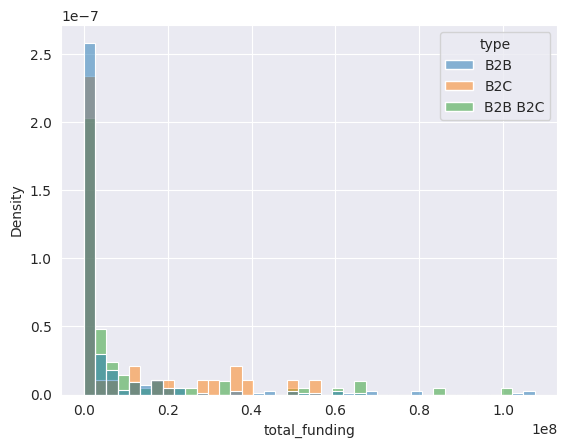

In [28]:
sns.histplot(df.loc[df['has_funding']==1], x='total_funding', bins=40, hue='type', common_norm=False, stat="density")


<Axes: xlabel='total_funding', ylabel='Proportion'>

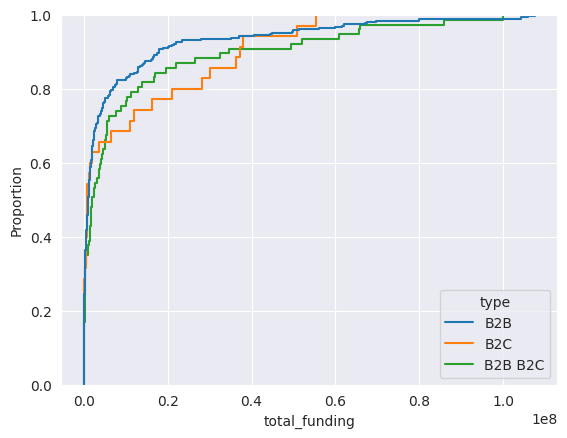

In [29]:
sns.ecdfplot(data=df.loc[df['has_funding']==1], x='total_funding', hue='type')

<Axes: xlabel='total_funding', ylabel='Proportion'>

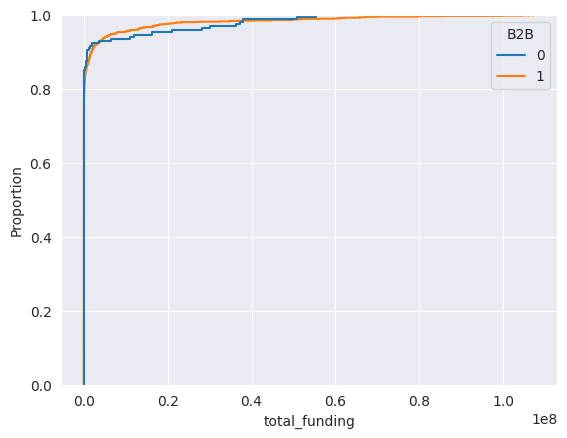

In [30]:
sns.ecdfplot(data=df, x='total_funding', hue='B2B')

<Axes: xlabel='total_funding', ylabel='Proportion'>

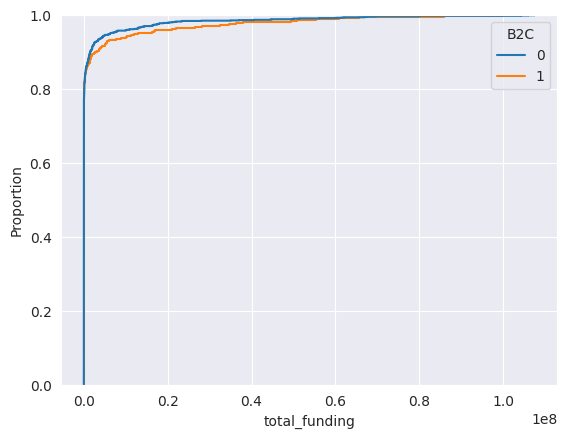

In [31]:
sns.ecdfplot(data=df, x='total_funding', hue='B2C')

By checking the total_funding distributions on both populations, one can conclude that the values are too disperse and probably won't contribute significativelly for model convergence in training. On the other hand, the categorical feature "has_funding" may be useful for fitting, as the majority of companies with funding are B2B. 

<Axes: xlabel='has_funding', ylabel='count'>

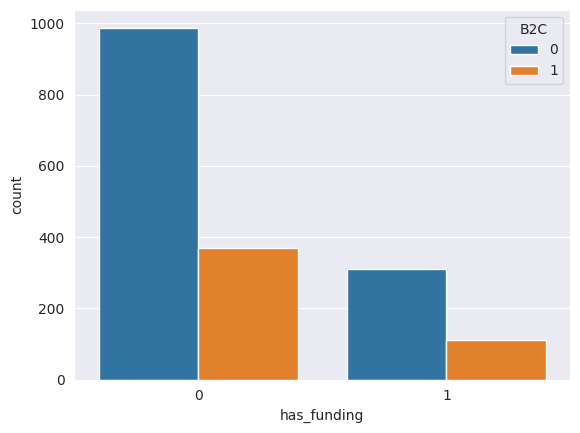

In [32]:
sns.countplot(data=df, x='has_funding', hue='B2C')

<Axes: xlabel='has_funding', ylabel='count'>

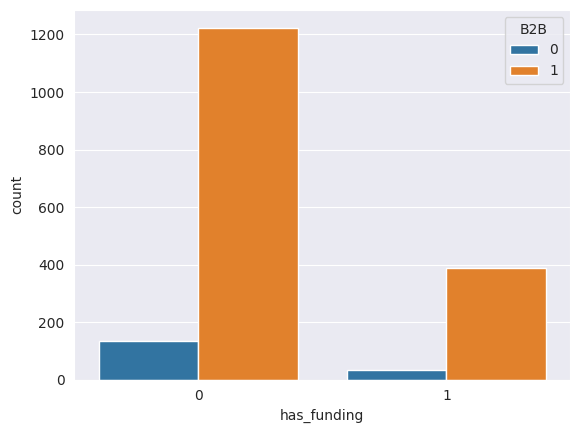

In [33]:
sns.countplot(data=df, x='has_funding', hue='B2B')

<Axes: xlabel='type', ylabel='total_funding'>

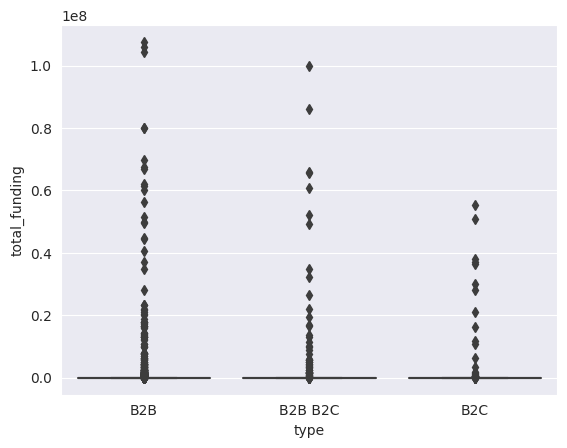

In [34]:
sns.boxplot(data=df, x='type', y='total_funding')

### Founded
---

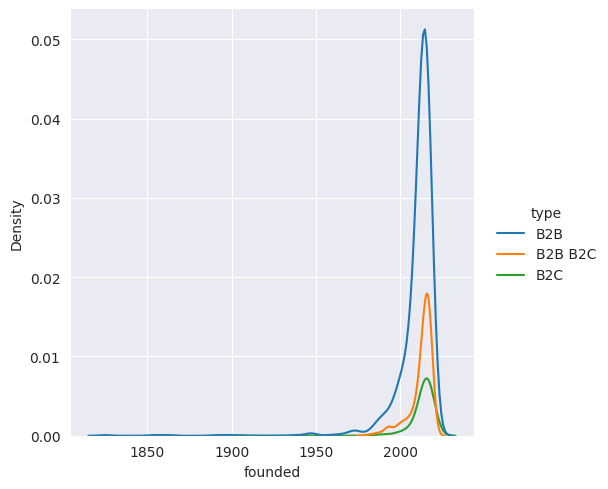

In [35]:
sns.displot(data=df, x='founded', kind='kde', hue='type')

<Axes: xlabel='founded', ylabel='Proportion'>

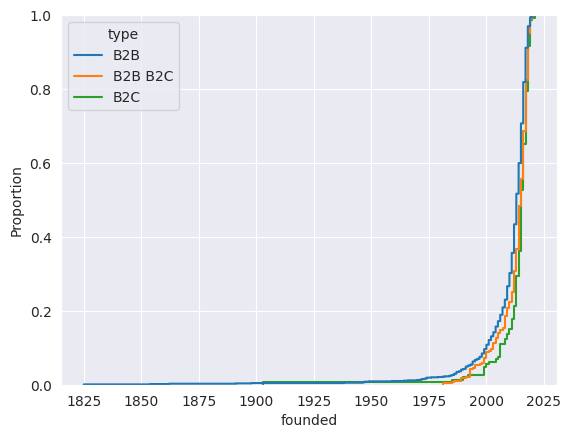

In [36]:
sns.ecdfplot(data=df, x='founded',  hue='type')

<Axes: xlabel='type', ylabel='founded'>

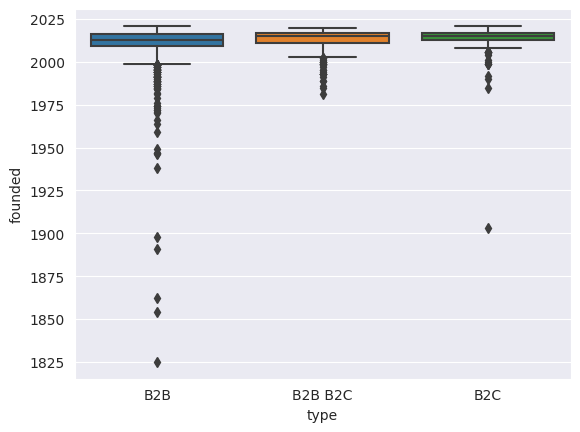

In [37]:
sns.boxplot(data=df, x='type', y='founded')

### Employees
---

In [38]:
# df = remove_top_outliers(df, 'employees_on_linkedin', 0.1)

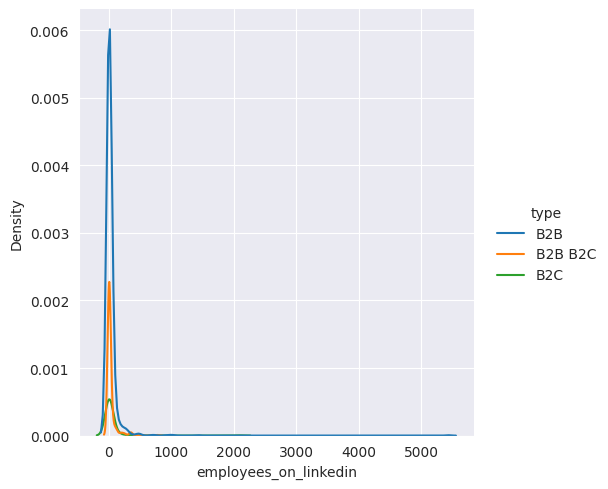

In [39]:
sns.displot(data=df, x='employees_on_linkedin', kind='kde', hue='type')

<Axes: xlabel='employees_on_linkedin', ylabel='Proportion'>

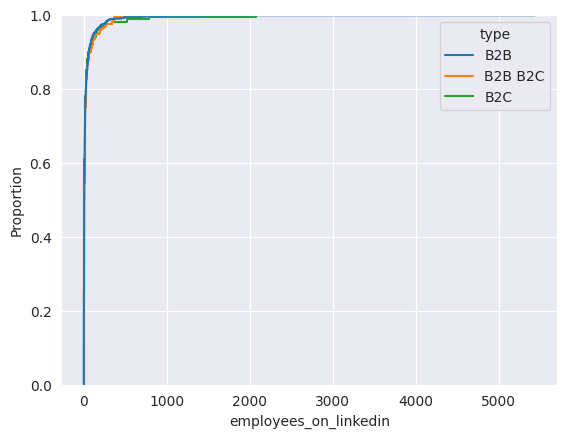

In [40]:
sns.ecdfplot(data=df, x='employees_on_linkedin',  hue='type')

<Axes: xlabel='type', ylabel='employees_on_linkedin'>

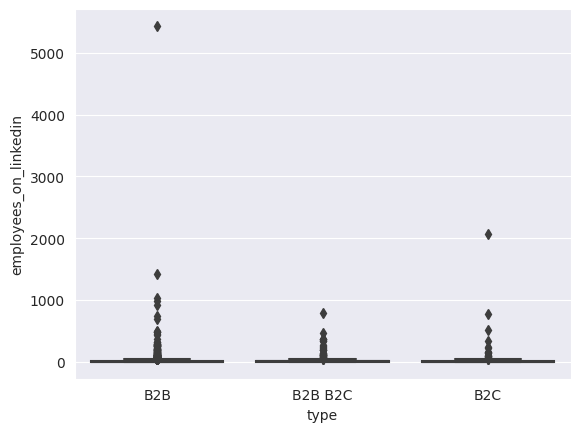

In [41]:
sns.boxplot(data=df, x='type', y='employees_on_linkedin')

### Followers
---

In [42]:
# df = remove_top_outliers(df, 'followers', 0.1)

<Axes: xlabel='followers', ylabel='Density'>

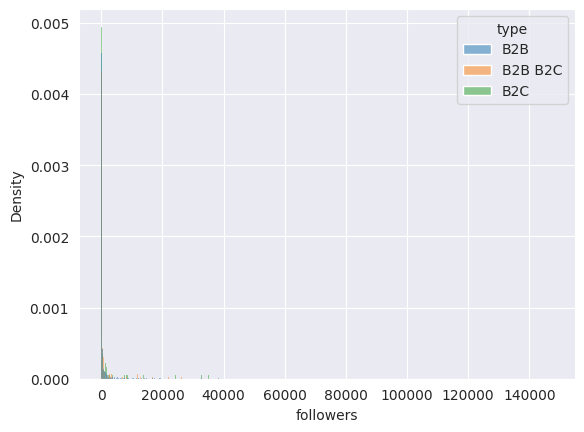

In [43]:
sns.histplot(data=df, x='followers', common_norm=False, stat="density", hue='type')

<Axes: xlabel='followers', ylabel='Proportion'>

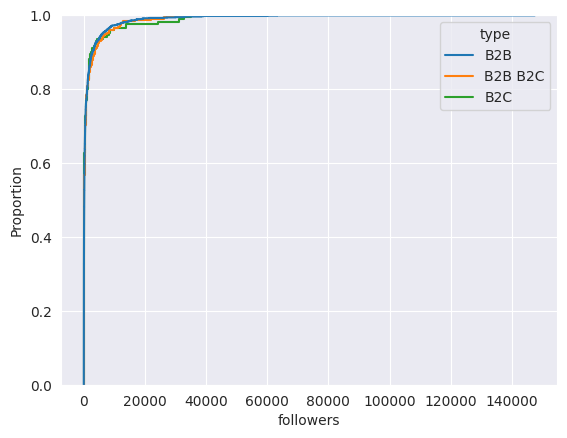

In [44]:
sns.ecdfplot(data=df, x='followers',  hue='type')

<Axes: xlabel='type', ylabel='followers'>

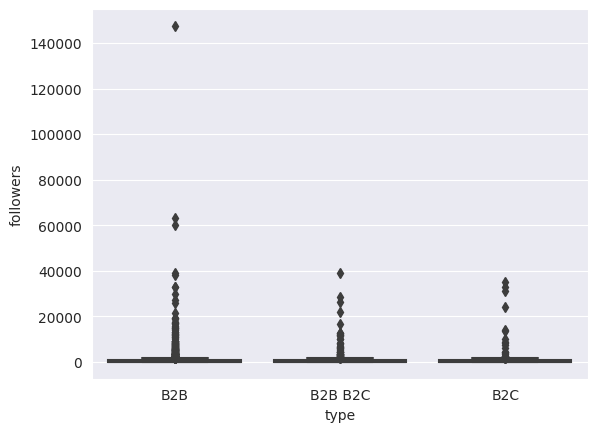

In [45]:
sns.boxplot(data=df, x='type', y='followers')

### Events
---

In [46]:
df.has_events.value_counts()

0    1707
1      74
Name: has_events, dtype: int64

In [47]:
df.loc[df.B2B==1].has_events.value_counts()

0    1543
1      69
Name: has_events, dtype: int64

In [48]:
df.loc[df.B2C==1].has_events.value_counts()

0    462
1     20
Name: has_events, dtype: int64

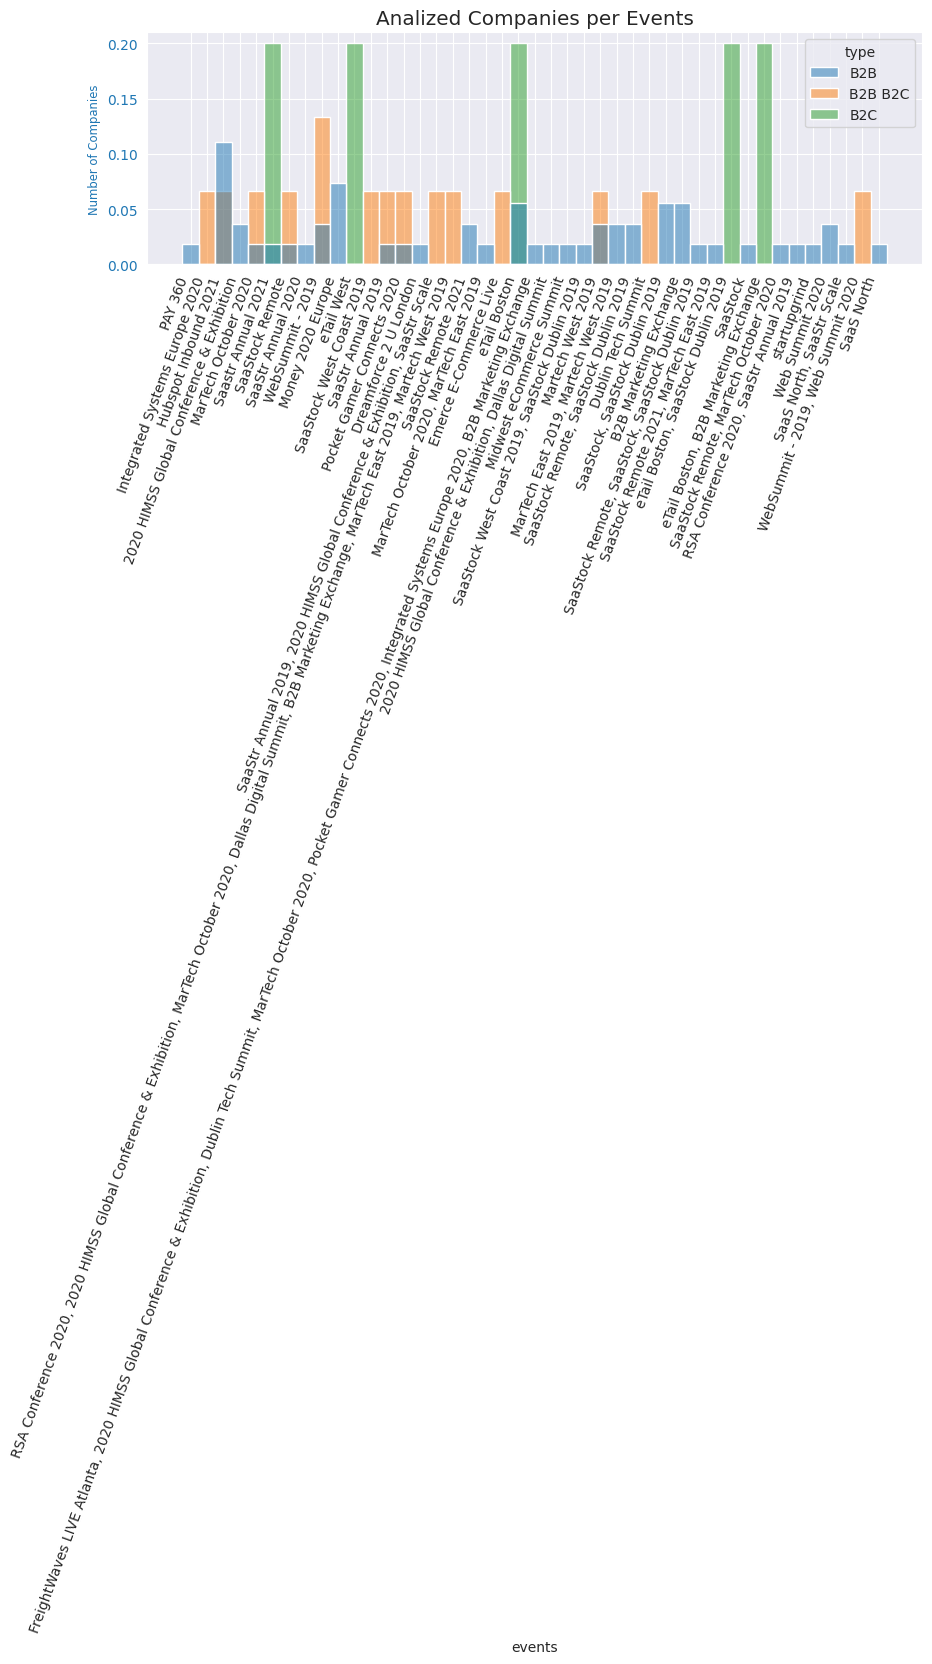

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df, x='events', hue='type', common_norm=False, stat="density")

# # title and axis
ax.set_title('Analized Companies per Events',  size='x-large')
ax.set_ylabel('Number of Companies', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

### Company Hubs
---

In [50]:
df.has_hubs.value_counts()

0    1454
1     327
Name: has_hubs, dtype: int64

In [51]:
df_b2c["has_hubs"].value_counts(dropna=False)

0    411
1     76
Name: has_hubs, dtype: int64

In [52]:
df_b2b["has_hubs"].value_counts(dropna=False)

0    1311
1     316
Name: has_hubs, dtype: int64

### Countries
---

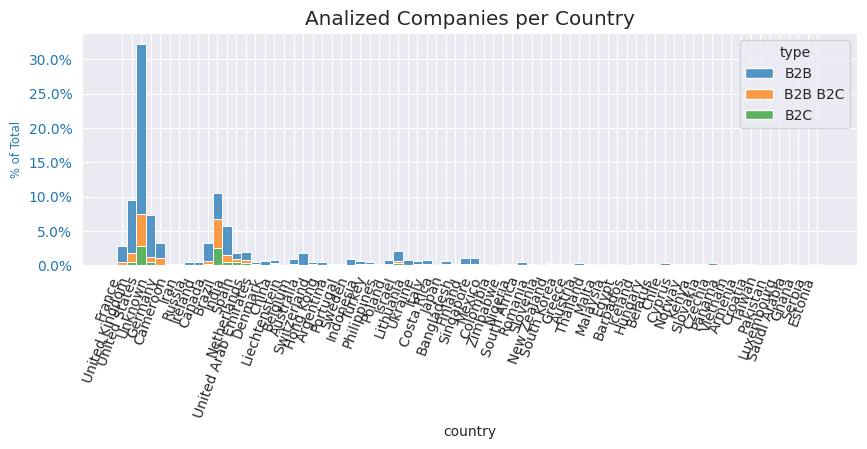

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df, x='country', hue='type', discrete=True, stat='percent', multiple="stack")

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

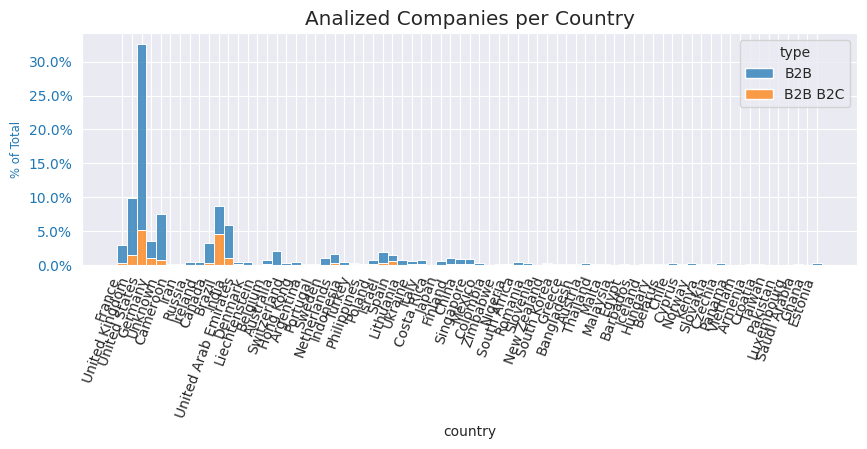

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df_b2b, x='country', hue='type', discrete=True, stat='percent', multiple="stack",)

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

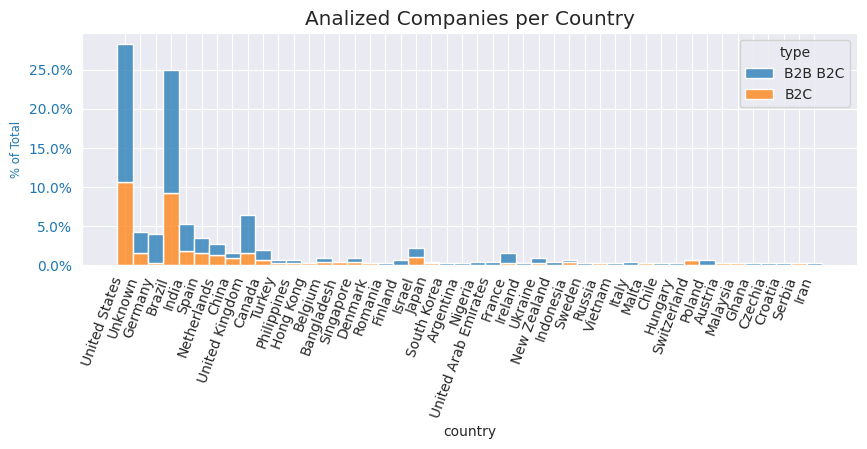

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df_b2c, x='country', hue='type', discrete=True, stat='percent', multiple="stack",)

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

## Text Features
---

In [56]:
df[['name', 'overview', 'industry', 'specialties', 'technologies', 'categories', 'type']]

,name,overview,industry,specialties,technologies,categories,type
0,Supli,Lib√©rez votre activit√© avec la plateforme de...,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",NaN,NaN,B2B
1,Bandwidth Recruitment,Bandwidth Recruitment is an independent specia...,Staffing and Recruiting,Cards and payments recruitment,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B
2,VCV.AI,VCV automates 4 steps of recruitment in one fr...,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,"Scalable Press Employees, Location, Careers",At Scalable Press we're building the next gene...,Printing,"Promotional Products Supplier, Industrial Auto...","HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C
4,Stuffwrap,Stuffwrap is a platform where you turn your wi...,Information Services,"Sale and swap your stuff, Buying and selling, ...",Microsoft ASP.NET,"Information Services, Social Network,",B2C
...,...,...,...,...,...,...,...
1794,BB Holdings,Innovation | Solutions | Consulting\n\nBusines...,Executive Office,"Wellness Management, Entertainment & Film, and...",Campaign Monitor,"Financial Services,",B2B
1795,Adan Corporate,Adan Corporate provides a wide range of bespok...,Management Consulting,"Mergers & Acquisitions, Financial modelling, S...",NaN,"Information Technology, Consulting, CRM,",B2B
1796,Stafford Consulting Engineers,Stafford Consulting Engineers is headquartered...,Facilities Services,"Forensic Investigations, Roof Asset Management...",NaN,"Construction, Facilities Support Services, , A...",B2B
1797,LeadSecure,LeadSecure is the next evolution in lead gener...,Real Estate,"real estate technology, lead generation","YouTube, Amazon Route 53","Internet, Mobile, Video Streaming, Real Estate,",B2B


# Data Preprocessing - Feature Engineering
---

### Removing Columns

In this step I remove some of the Dataset columns which are not likely to be useful for our model prediction fit.

By removing geospatial data such as City, State, Country and HQ , I also avoid Geospatial Biases to be produced by the model, ....

The company overview does **contain very useful information** on the company "type", but given the unstructured nature of the data and the time constraints on the project at hand, I have decided not to dabble too much on feature engineering over the descriptive texts and disregard the "overview" on my classification model. 

there is also too little data on 'company_hubs', 'events' and 'alexa_ranking' with a significant ammount of missing values for those fields on the provided dataset. For that reason I have also chosen not to use those fields on the company type classification model training.

In [57]:
df_clean = df.drop(columns=['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'linkedin_url', 'overview', 'sic_codes', 'company_hubs', 'events'])

In [58]:
df_clean

,employees_on_linkedin,followers,founded,industry,ownership_type,size,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C
0,22,1074,2017.0,Restaurants,Partnership,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0
1,2,484,2009.0,Staffing and Recruiting,Privately Held,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0
2,40,877,2017.0,Information Technology and Services,Privately Held,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0
3,112,11322,2012.0,Printing,Public Company,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C,0,1,0,1,1
4,0,21,2012.0,Information Services,Public Company,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,"Information Services, Social Network,",B2C,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,2,6,NaN,Executive Office,Privately Held,0-1 employees,"Wellness Management, Entertainment & Film, and...",0,Campaign Monitor,"Financial Services,",B2B,0,0,0,1,0
1795,22,123,2013.0,Management Consulting,Privately Held,NaN,"Mergers & Acquisitions, Financial modelling, S...",0,NaN,"Information Technology, Consulting, CRM,",B2B,0,0,0,1,0
1796,3,89,1964.0,Facilities Services,Privately Held,11-50 employees,"Forensic Investigations, Roof Asset Management...",0,NaN,"Construction, Facilities Support Services, , A...",B2B,0,0,0,1,0
1797,0,15,2014.0,Real Estate,Privately Held,2-10 employees,"real estate technology, lead generation",125000,"YouTube, Amazon Route 53","Internet, Mobile, Video Streaming, Real Estate,",B2B,1,0,0,1,0


### Feature Engineering
---

#### size:
we need to preprocess the strings to exctract information

In [59]:
df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')

<ipython-input-59-1909f25729f6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')


<Axes: xlabel='size', ylabel='Count'>

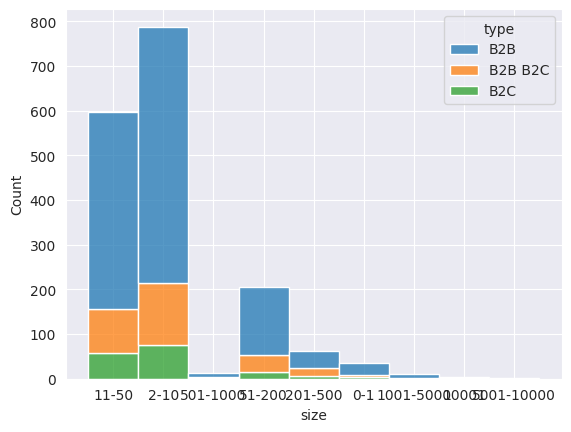

In [60]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

In [61]:
df_clean.loc[df_clean['size']=='10001', 'size']='500+'
df_clean.loc[df_clean['size']=='5001-10000', 'size']='500+'
df_clean.loc[df_clean['size']=='1001-5000', 'size']='500+'
df_clean.loc[df_clean['size']=='501-1000', 'size']='500+'
df_clean.loc[df_clean['size']=='201-500', 'size']='201-500'
df_clean.loc[df_clean['size']=='0-1', 'size']='1-10'
df_clean.loc[df_clean['size']=='2-10', 'size']='1-10'

In [62]:
df_clean['size'].value_counts()

1-10       823
11-50      596
51-200     206
201-500     61
500+        27
Name: size, dtype: int64

<Axes: xlabel='size', ylabel='Count'>

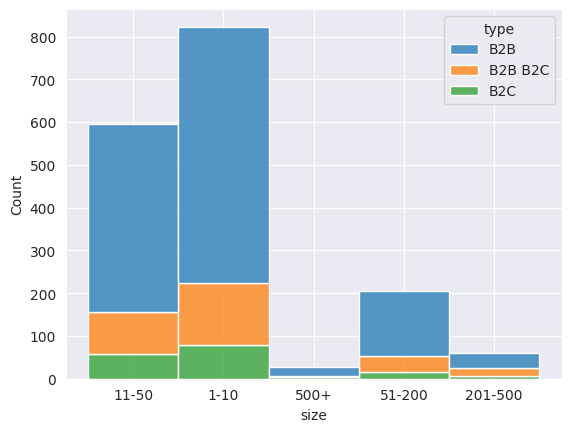

In [63]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

### ownership_type:

In [64]:
df_clean.ownership_type.value_counts(dropna=False)

Privately Held         1331
Public Company          136
NaN                     121
Partnership             114
Self Owned               30
Sole Proprietorship      16
Self Employed            11
Non Profit                8
Educational               7
Self-Employed             5
Government Agency         1
Nonprofit                 1
Name: ownership_type, dtype: int64

In [65]:
df_clean.loc[df_clean['ownership_type']=='Nonprofit', 'ownership_type']='Non Profit'

df_clean.loc[(df_clean['ownership_type']=='Self-Employed') | 
             (df_clean['ownership_type']=='Self Owned') |
             (df_clean['ownership_type']=='Sole Proprietorship')\
             , 'ownership_type']='Self Employed'

df_clean.loc[(df_clean['ownership_type']=='Government Agency') |
             (df_clean['ownership_type'].isnull()) |
             (df_clean['ownership_type']=='Non Profit') |
             (df_clean['ownership_type']=='Educational'), 'ownership_type']='Other'


<Axes: xlabel='ownership_type', ylabel='Density'>

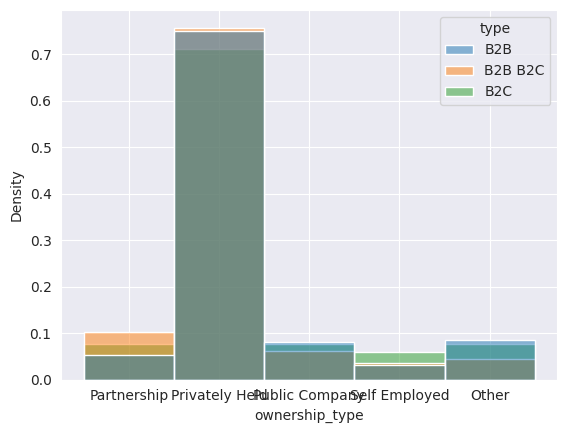

In [66]:
sns.histplot(data=df_clean, x='ownership_type', hue='type',  common_norm=False, stat="density")

## One-Hot-Encoding Categorical Variables 
---

In [67]:
df_clean.columns

Index(['employees_on_linkedin', 'followers', 'founded', 'industry',
       'ownership_type', 'size', 'specialties', 'total_funding',
       'technologies', 'categories', 'type', 'has_funding', 'has_events',
       'has_hubs', 'B2B', 'B2C'],
      dtype='object')

In [68]:
cat_cols = ['ownership_type', 'size']

In [69]:
for col in cat_cols:

  # Get one hot encoding of columns B
  one_hot = pd.get_dummies(df_clean[col])
  # Drop column B as it is now encoded
  df_clean = df_clean.drop(columns=[col],axis = 1)
  # Join the encoded df
  df_clean = df_clean.join(one_hot)

In [70]:
df_clean.head()

,employees_on_linkedin,followers,founded,industry,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C,Other,Partnership,Privately Held,Public Company,Self Employed,1-10,11-50,201-500,500+,51-200
0,22,1074,2017.0,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,2,484,2009.0,Staffing and Recruiting,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0
2,40,877,2017.0,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0
3,112,11322,2012.0,Printing,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0
4,0,21,2012.0,Information Services,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,"Information Services, Social Network,",B2C,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


## Feature Scaling
---

In [71]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['employees_on_linkedin', 'followers', 'founded']

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_clean[cols_to_scale])

# Transform the selected columns with the fitted scaler
df_clean[cols_to_scale] = scaler.transform(df_clean[cols_to_scale])

In [72]:
df_clean[cols_to_scale]

,employees_on_linkedin,followers,founded
0,-0.065928,-0.058531,0.507042
1,-0.190220,-0.166734,-0.139792
2,0.045934,-0.094660,0.507042
3,0.493383,1.820885,0.102771
4,-0.202649,-0.251645,0.102771
...,...,...,...
1794,-0.190220,-0.254396,NaN
1795,-0.065928,-0.232939,0.183625
1796,-0.184005,-0.239174,-3.778234
1797,-0.202649,-0.252745,0.264480


In [73]:
df_clean.to_csv('df_clean.csv')

## Text Features: NLP for feature extraction
---

The information contained on the ***SPECIALTIES,  CATEGORIES, INDUSTRY and TECHNOLOGIES*** columns is valuable for gaining insights on the businesses' operation/type.

By applying NLP techniques to text data, we can **create new features** that capture important aspects of the language used in texts. These features can then be **used as inputs** to machine learning algorithms, such as XGBoost, to improve their performance.

There are two stages to this process:

1) Firstly, I have used **GPT-3.5** (via the *ChatGPT* interface) as a tool for defining features to be extracted from texts:
  
  - This can be seen as a simple summarization task: by creating batches of randomly sampled texts from each of the features' corpus, I have summarized their content in 15-20 different **categories** or **characteristics**. This process has been repeated several times and throughout the whole dataset, as to avoid biases that could have been produced by different batches.

  - I could have used the free API to provide a complete pipeline of feature extraction inside this notebook, but given the time constraints for the project, I have chosen not to.

 - Note: I thoroughly believe that large language models are very useful for automating a specific set of tasks and should be considered as a valid alternative or tool to be used, with the required caution. I had tried common summarization techiniques on the texts over this specific task, by using tokenizers and word counting, but have achieved better results with the large language model. 

2) Secondly, I have used facebook's **BART** for **feature extraction** over text data:
  
  - The idea is to categorize the text over the different 'characteristics' extracted by GPT-3.5. The model returns us tensors of the probabilities of the text being adequate to each provided category. 

  - The returned probabilites are a **float point value that range from 0-1** for each of the 15-20 defined categories.  
  
  - I have chosen BART because of it's **state of the art performance** on categorization tasks over texts, and also because of the convenience of using a ready-to-deploy **pipeline()** from Huggingface Transformers over a custom set of labels.

### Imports and Configs
---

In [74]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from sklearn.feature_extraction.text import CountVectorizer

In [75]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [76]:
df_txt = df_clean.copy()

### specialties:
specialties provides us with valuable information on the company's industry. For the information to be useful, NLP preprocessing must be used for feature extraction, as the terms are too diverse and one-hot encoding of the categories as they are would not be feaseble

In [ ]:
# for spec in df_clean['specialties'].value_counts().keys():
#   print(spec)

In [78]:
list_of_specialties = df.loc[df['specialties'].notnull()]['specialties'].tolist()

In [256]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as',  ]

for row in df.loc[df['specialties'].notnull()]['specialties'].tolist():
    # Split the text into individual words
    words = row.split()
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
# print(list(word_count.keys())[:600])
# print(len(word_count))

In [255]:
# sample_specialty = df.loc[df['specialties'].notnull()]['specialties'].sample(n=80)
# print(''.join(sample_specialty.values))

In [ ]:
specialty_labels = [
  'E-commerce',
  'SaaS solutions and Cloud solutions',
  'Marketing and advertising services',
  'Financial services and investment',
  'IT support and cybersecurity',
  'Market Research',
  'Recruitment and human resources',
  'Sustainability and ethical production',
  'Mobile applications',
  'Artificial Intelligence and Machine Learning',
  'Social Media Marketing and Management',
  'Augmented and Virtual Reality',
  'Energy Solutions',
  'Customization and Personalization',
  'Customer Service/Experience'
  'Social Media',
  'Analytics'
]

In [82]:
len(specialty_labels)

16

In [83]:
df_txt[specialty_labels] = 0

In [84]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=specialty_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['specialties']):
      continue
    cat = row['specialties']
    predicted_category = classifier(cat, candidate_labels=specialty_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 10/1781 [00:09<19:07,  1.54it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [19:06<00:00,  1.55it/s]


In [85]:
df_txt[specialty_labels]

,E-commerce,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Market Research,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics
0,0.022725,0.148686,0.046047,0.044551,0.035700,0.051374,0.042514,0.113268,0.055642,0.051325,0.045087,0.027675,0.030762,0.111821,0.080136,0.092688
1,0.101111,0.032355,0.041732,0.102855,0.025997,0.063494,0.096007,0.033300,0.194787,0.022139,0.037541,0.031015,0.038033,0.100788,0.038336,0.040510
2,0.001452,0.003212,0.001558,0.002482,0.002356,0.004784,0.923925,0.003163,0.007253,0.020917,0.003754,0.004081,0.003164,0.006559,0.003332,0.008007
3,0.075539,0.014354,0.339087,0.010941,0.011991,0.028182,0.014308,0.016532,0.036873,0.020472,0.022748,0.016921,0.016149,0.328364,0.020041,0.027497
4,0.317881,0.033372,0.074596,0.045205,0.015310,0.026160,0.016564,0.096701,0.073827,0.029709,0.034046,0.029840,0.021139,0.073865,0.060330,0.051454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.017547,0.026390,0.491228,0.011568,0.011286,0.025962,0.020048,0.121764,0.039154,0.014762,0.034397,0.034293,0.015719,0.075365,0.040455,0.020062
1795,0.008276,0.007837,0.006833,0.869233,0.006344,0.009855,0.006501,0.008402,0.011780,0.008296,0.007823,0.008459,0.009454,0.007995,0.006513,0.016400
1796,0.034783,0.032167,0.019032,0.030563,0.033874,0.144810,0.033525,0.149027,0.060897,0.035238,0.033266,0.047113,0.037126,0.149351,0.041380,0.117847
1797,0.032386,0.032611,0.133537,0.040188,0.027966,0.078022,0.082869,0.051486,0.051437,0.026844,0.058560,0.040100,0.034931,0.141493,0.057150,0.110421


### categories:
categories also provides us with valuable information on the company's actuation sector. There are 1537 distinct values for industry, so some category grouping needs to be done

In [86]:
df_clean.categories.value_counts()

Advertising, Marketing,                                                                                                          21
Marketing,                                                                                                                       13
E-Commerce, ,                                                                                                                    13
Software,                                                                                                                        11
E-Commerce,                                                                                                                      11
                                                                                                                                 ..
Internet, Retail, E-Commerce, Home Decor, Interior Design,                                                                        1
Information Technology, Artificial Intelligence, Software, Automotive, Logis

In [254]:
print(len(df_clean['categories'].value_counts()))

# for cat in df_clean['categories'].value_counts().keys()[1500:]:
#   print(cat)

1520


In [253]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as', ',' ]

for row in df.loc[df['categories'].notnull()]['categories'].tolist():
    # Split the text into individual words
    words = row.split()
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
# print(word_count)
# print(len(word_count))

In [89]:
category_labels = [
'Software/IT',
'E-commerce',
'Marketing/Advertising',
'Consulting/Services',
'Human Resources',
'Artificial Intelligence',
'Social Media',
'Mobile/Apps',
'Financial Services',
'Retail',
'Education/ Learning',
'Real Estate',
'Manufacturing',
'Healthcare/Wellness',
'Transportation/Logistics',
'Hospitality',
'Market Research',
'Saas',
'Public Relations'
]

print(len(category_labels))

19


In [90]:
df_txt[category_labels] = 0

In [91]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=category_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['categories']):
      continue
    cat = row['categories']
    predicted_category = classifier(cat, candidate_labels=category_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 11/1781 [00:07<25:35,  1.15it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [29:26<00:00,  1.01it/s]


In [92]:
df_txt[category_labels+['type']]

,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,type
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,B2B
1,0.001982,0.001839,0.001922,0.687978,0.258624,0.001916,0.003487,0.003355,0.007906,0.001824,0.001666,0.001402,0.001517,0.002650,0.001874,0.002069,0.005615,0.009232,0.003143,B2B
2,0.001979,0.001143,0.001576,0.004123,0.384585,0.565721,0.003230,0.002376,0.001900,0.001878,0.003438,0.001017,0.001337,0.002258,0.001582,0.002746,0.004239,0.012288,0.002585,B2B
3,0.157027,0.023646,0.007996,0.015948,0.009799,0.027661,0.016789,0.031706,0.008350,0.544780,0.009379,0.008480,0.028942,0.011430,0.013083,0.009662,0.012674,0.054574,0.008074,B2B B2C
4,0.020481,0.008836,0.008916,0.024808,0.010995,0.011043,0.712386,0.037928,0.007681,0.008980,0.017418,0.006064,0.006909,0.010201,0.008700,0.012088,0.011454,0.053175,0.021939,B2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.003541,0.003901,0.003246,0.014946,0.002911,0.002372,0.002901,0.005068,0.908409,0.004149,0.002304,0.003020,0.002883,0.002849,0.003254,0.002821,0.004870,0.023748,0.002807,B2B
1795,0.180597,0.006456,0.005834,0.667718,0.006366,0.006455,0.009647,0.009266,0.005428,0.005129,0.004736,0.003974,0.005104,0.006360,0.005455,0.005800,0.033869,0.025362,0.006443,B2B
1796,0.036559,0.022766,0.024445,0.099980,0.046158,0.026378,0.033858,0.037863,0.043588,0.030157,0.024311,0.064801,0.058719,0.053589,0.059312,0.062068,0.037045,0.204951,0.033451,B2B
1797,0.006941,0.010608,0.007281,0.013875,0.005700,0.007269,0.070278,0.177423,0.008377,0.017186,0.005942,0.600315,0.003641,0.005861,0.005876,0.007825,0.012834,0.026201,0.006568,B2B


### industry:
industry provides us with valuable information on the company's actuation sector. There are only 114 distinct values for industry, thus we will try to one-hot encode these categories without more complex feature engineering on the first attempt

In [93]:
df_clean.industry.value_counts()

Information Technology and Services     314
Internet                                254
Computer Software                       203
Marketing and Advertising               189
Financial Services                       61
                                       ... 
Maritime                                  1
Non-Profit Organization Management        1
Alternative Dispute Resolution            1
Mining & Metals                           1
Recreational Facilities and Services      1
Name: industry, Length: 114, dtype: int64

In [252]:
# for ind in df_clean['industry'].value_counts().keys():
#   print(ind)

In [95]:
industry_labels = [
  'Technology and Software',
  'Marketing and Advertising',
  'Finance and Investment', 
  'Consulting and Professional Services',
  'Real Estate and Property',
  'Retail and Consumer Goods',
  'Hospitality and Tourism',
  'Healthcare and Medical Devices',
  'Transportation and Logistics',
  'Education',
  'Non-profit',
  'Energy & Utilities',
  'Telecommunications',
  'Agriculture',
  'Environmental',
  'Legal Services'
] 

In [96]:
len(industry_labels)

16

In [97]:
df_txt[industry_labels] = 0

In [98]:
df_clean['industry']

0                               Restaurants
1                   Staffing and Recruiting
2       Information Technology and Services
3                                  Printing
4                      Information Services
                       ...                 
1794                       Executive Office
1795                  Management Consulting
1796                    Facilities Services
1797                            Real Estate
1798                              Insurance
Name: industry, Length: 1781, dtype: object

In [99]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=industry_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['industry']):
      continue
    ind = row['industry']
    predicted_category = classifier(ind, candidate_labels=industry_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 10/1781 [00:12<29:13,  1.01it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [19:25<00:00,  1.53it/s]


In [100]:
df_txt[industry_labels]

,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services
0,0.010621,0.013688,0.011821,0.018029,0.013290,0.019970,0.766112,0.011190,0.012472,0.010990,0.040678,0.014308,0.015523,0.013813,0.015129,0.012367
1,0.048097,0.044037,0.038840,0.094051,0.058559,0.073007,0.050637,0.061579,0.053914,0.060545,0.089616,0.067229,0.098499,0.045269,0.051062,0.065060
2,0.413317,0.018959,0.016033,0.056343,0.016078,0.020071,0.014299,0.038584,0.023638,0.017878,0.026137,0.027310,0.267379,0.013840,0.014125,0.016009
3,0.051140,0.072406,0.046989,0.096518,0.072226,0.058098,0.062119,0.063893,0.066039,0.050020,0.068099,0.069093,0.069258,0.035671,0.057525,0.060906
4,0.242843,0.033785,0.030354,0.069282,0.031801,0.024547,0.021174,0.036068,0.033124,0.053352,0.041247,0.032552,0.304518,0.017586,0.016582,0.011186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.073423,0.062357,0.069995,0.112649,0.073279,0.041570,0.049796,0.043046,0.058858,0.046969,0.067891,0.071687,0.066320,0.037107,0.045046,0.080007
1795,0.022603,0.033228,0.025817,0.632232,0.037265,0.021879,0.020141,0.024802,0.029591,0.015479,0.032994,0.028863,0.022405,0.014968,0.018983,0.018751
1796,0.047001,0.034518,0.036814,0.068145,0.048644,0.033323,0.101487,0.090625,0.068754,0.038784,0.056080,0.189325,0.099439,0.027577,0.035741,0.023742
1797,0.009126,0.018384,0.014190,0.022646,0.792264,0.017486,0.010365,0.011109,0.010978,0.010736,0.024408,0.011991,0.012434,0.011523,0.010465,0.011896


### Technologies:

In [101]:
df_clean.technologies.value_counts()

YouTube                                                                                                                      44
Google AdWords                                                                                                               41
HubSpot                                                                                                                      26
LinkedIn Ads                                                                                                                 22
Tawk.to                                                                                                                      17
                                                                                                                             ..
HubSpot, Pardot, Salesforce, YouTube, Salesforce Pardot, Eventbrite, Drift                                                    1
YouTube, Nodejs, Expressjs                                                                              

In [251]:
print(len(df_clean['technologies'].value_counts()))
# for tech in df_clean['technologies'].value_counts().keys()[500:750]:
#   print(tech)

735


In [103]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as', ',' ]

for row in df.loc[df['technologies'].notnull()]['technologies'].tolist():
    # Split the text into individual words
    words = row.split(',')
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
print(word_count.keys())
print(len(word_count))

dict_keys([' Google AdWords', ' LinkedIn Ads', 'HubSpot', ' YouTube', ' Amazon Route 53', ' Zendesk', ' Hubspot Form Builder', ' New Relic', ' Sendgrid', 'YouTube', ' WordPress', ' Unbounce', 'Amazon Cloudfront', ' Salesforce', ' Microsoft Office 365', ' HubSpot', ' MailChimp', ' Zendesk Support', ' Mailgun', 'New Relic', ' Amazon SES', ' Amazon Web Services', 'Google AdWords', ' Google Cloud DNS', 'Amazon Web Services', 'Intercom', 'MailChimp', 'Google Cloud', ' Drift', ' Intercom', 'LinkedIn Ads', ' Tawk.to', 'Tawk.to', ' Next.js', ' Expressjs', 'Google AdSense', ' Nodejs', ' Salesforce Pardot', ' Stripe', ' Java', ' Mixpanel', 'Drupal', ' Marketo', 'Amazon S3', ' Segment', ' Zendesk JavaScript API', ' React', ' Zendesk Chat', ' Pardot', ' Eventbrite', ' Hubspot CMS', ' Marketo Email', ' Microsoft ASP.NET', ' WooCommerce', 'Next.js', 'Microsoft ASP.NET', ' Vuejs', ' Tidio', 'LiveChat', 'Angular', ' AngularJS', 'Salesforce', ' Microsoft Azure', ' Drupal', 'Nodejs', ' LiveChat', ' Goog

In [104]:
tech_stack_dict = {
  "Google AdWords": ["advertising"],
  "LinkedIn Ads": ["advertising"],
  "HubSpot": ["customer relationship", "email marketing", "website analytics", "event management"],
  "YouTube": ["video sharing and streaming"],
  "Amazon Route 53": ["cloud computing", "website hosting"],
  "Zendesk": ["customer relationship", "live chat and messaging"],
  "Hubspot Form Builder": ["customer relationship", "email marketing"],
  "New Relic": ["cloud computing", "website analytics"],
  "Sendgrid": ["email marketing"],
  "WordPress": ["website hosting", "e-commerce platforms"],
  "Unbounce": ["website analytics", "advertising"],
  "Amazon Cloudfront": ["cloud computing", "website hosting"],
  "Salesforce": ["customer relationship", "human resource management"],
  "Microsoft Office 365": ["cloud computing", "human resource management"],
  "MailChimp": ["email marketing"],
  "Zendesk Support": ["customer relationship", "live chat and messaging"],
  "Mailgun": ["email marketing"],
  "Amazon SES": ["email marketing", "cloud computing"],
  "Amazon Web Services": ["cloud computing"],
  "Google Cloud DNS": ["cloud computing"],
  "Intercom": ["customer relationship", "live chat and messaging"],
  "Tawk.to": ["customer relationship", "live chat and messaging"],
  "Next.js": ["programming languages", "website hosting"],
  "Expressjs": ["programming languages"],
  "Google AdSense": ["advertising"],
  "Nodejs": ["programming languages"],
  "Salesforce Pardot": ["email marketing", "customer relationship"],
  "Stripe": ["payment gateways"],
  "Java": ["programming languages"],
  "Mixpanel": ["website analytics"],
  "Drupal": ["website hosting", "e-commerce platforms"],
  "Marketo": ["email marketing", "customer relationship", "event management"],
  "Amazon S3": ["cloud computing", "website hosting"],
  "Segment": ["website analytics"],
  "Zendesk JavaScript API": ["customer relationship", "live chat and messaging"],
  "React": ["programming languages"],
  "Zendesk Chat": ["customer relationship", "live chat and messaging"],
  "Pardot": ["email marketing", "customer relationship"],
  "Eventbrite": ["event management"],
  "Hubspot CMS": ["e-commerce platforms", "website hosting"],
  "Marketo Email": ["email marketing", "customer relationship", "event management"],
  "Microsoft ASP.NET": ["programming languages", "cloud computing"],
  "WooCommerce": ["e-commerce platforms"],
  "Vuejs": ["programming languages"]
}

In [105]:
tech_labels = ['customer relationship',
'advertising' ,
'video sharing and streaming',
'website hosting',
'website analytics',
'email marketing',
'live chat and messaging',
'cloud computing',
'event management',
'payment gateways',
'human resource management',
'programming languages',
'e-commerce platforms']

In [106]:
df_txt[tech_labels] = 0

In [107]:
for index, row in df_txt.iterrows():
    if pd.isna(row['technologies']):
      continue
    techs = row['technologies'].split(',')
    for tech in techs:
        if tech in tech_stack_dict.keys():
          for cat in tech_stack_dict[tech]:
            df_txt.loc[index, cat] = 1



In [108]:
df_txt[tech_labels]

,customer relationship,advertising,video sharing and streaming,website hosting,website analytics,email marketing,live chat and messaging,cloud computing,event management,payment gateways,human resource management,programming languages,e-commerce platforms
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,1,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0,0,0,0,0,0,0,0,0,0,0,0,0
1795,0,0,0,0,0,0,0,0,0,0,0,0,0
1796,0,0,0,0,0,0,0,0,0,0,0,0,0
1797,0,0,1,0,0,0,0,0,0,0,0,0,0


In [109]:
df_txt.to_csv('df_txt.csv')

### Text Feature Scaling
---

I have used Standard Scaler as a means to properly scale the features extracted from the text labels. More experimentation on results could be made using MinMaxScaler or other scaling algorithms to check for better results.

In [110]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = category_labels + industry_labels + specialty_labels

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_txt[cols_to_scale])

# Transform the selected columns with the fitted scaler
df_txt[cols_to_scale] = scaler.transform(df_txt[cols_to_scale])

0 mean and 1 std!

In [111]:
df_txt[cols_to_scale].describe()

,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services,E-commerce,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Market Research,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics
count,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03
mean,-1.196872e-17,-3.790093e-17,-5.984358e-18,0.000000,2.393743e-17,-9.973929e-18,0.000000,6.084097e-17,0.000000,1.196872e-17,5.984358e-18,0.000000,-1.396350e-17,1.496089e-17,-7.979144e-18,-2.593222e-17,-5.984358e-18,-4.189050e-17,-5.984358e-18,-1.994786e-17,-1.196872e-17,-5.385922e-17,9.973929e-19,-1.595829e-17,2.892440e-17,3.989572e-18,-2.543352e-17,-3.989572e-18,2.593222e-17,-4.189050e-17,9.973929e-18,1.994786e-17,1.994786e-18,1.595829e-17,2.593222e-17,-3.790093e-17,-5.984358e-18,0.000000,-2.792700e-17,9.973929e-18,-5.984358e-18,-8.976537e-18,0.000000,4.887225e-17,3.989572e-18,4.189050e-17,-9.973929e-19,-1.994786e-18,-7.580186e-17,-1.895047e-17,2.593222e-17
std,1.000281e+00,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00
min,-5.071731e-01,-5.131583e-01,-3.814933e-01,-0.462018,-3.172422e-01,-3.307252e-01,-0.424860,-4.416643e-01,-0.311660,-3.315328e-01,-2.706899e-01,-0.207979,-2.446622e-01,-2.516573e-01,-2.561758e-01,-3.058809e-01,-3.701266e-01,-6.580304e-01,-2.903311e-01,-7.252286e-01,-4.372078e-01,-3.572742e-01,-5.071494e-01,-3.592507e-01,-3.728702e-01,-3.125023e-01,-4.595219e-01,-3.877597e-01,-3.155371e-01,-7.267784e-01,-7.296364e-01,-7.472366e-01,-2.763992e-01,-3.334093e-01,-3.647195e-01,-5.131583e-01,-3.929617e-01,-0.444928,-3.326173e-01,-3.404399e-01,-3.701266e-01,-3.283295e-01,-0.499969,-4.958423e-01,-3.537817e-01,-4.816362e-01,-4.625727e-01,-4.574723e-01,-6.359992e-01,-6.507314e-01,-4.538157e-01
25%,-4.867084e-01,-4.982523e-01,-3.653476e-01,-0.427261,-3.018586e-01,-3.081778e-01,-0.380623,-3.885772e-01,-0.292850,-2.936078e-01,-2.375067e-01,-0.188448,-2.164206e-01,-2.251217e-01,-2.258779e-01,-2.581854e

### Visualize Feature Distribution
---

In [112]:
len(category_labels)

19

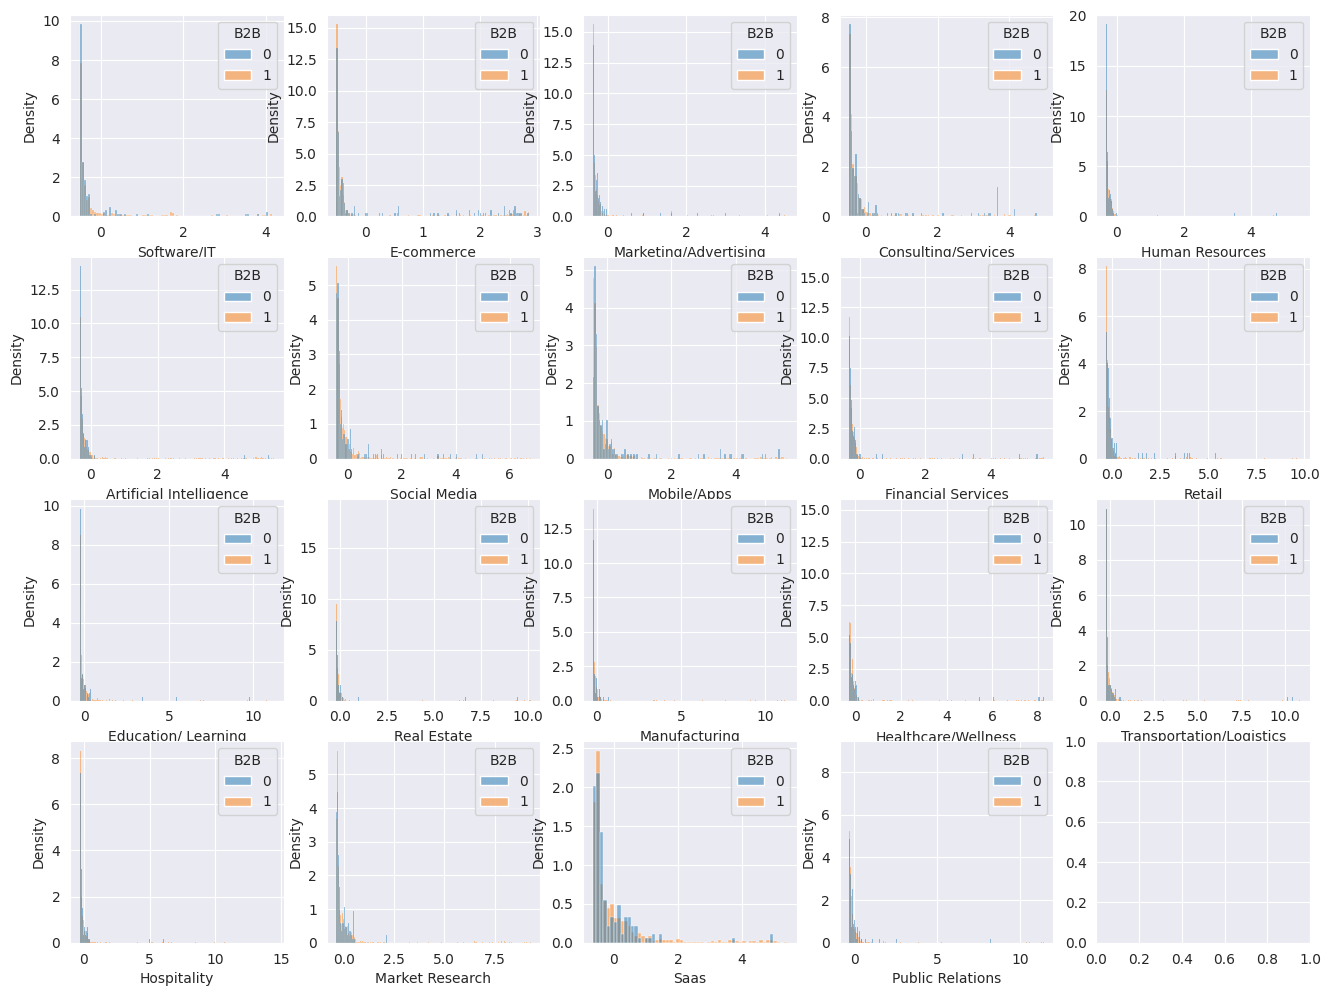

In [113]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(category_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

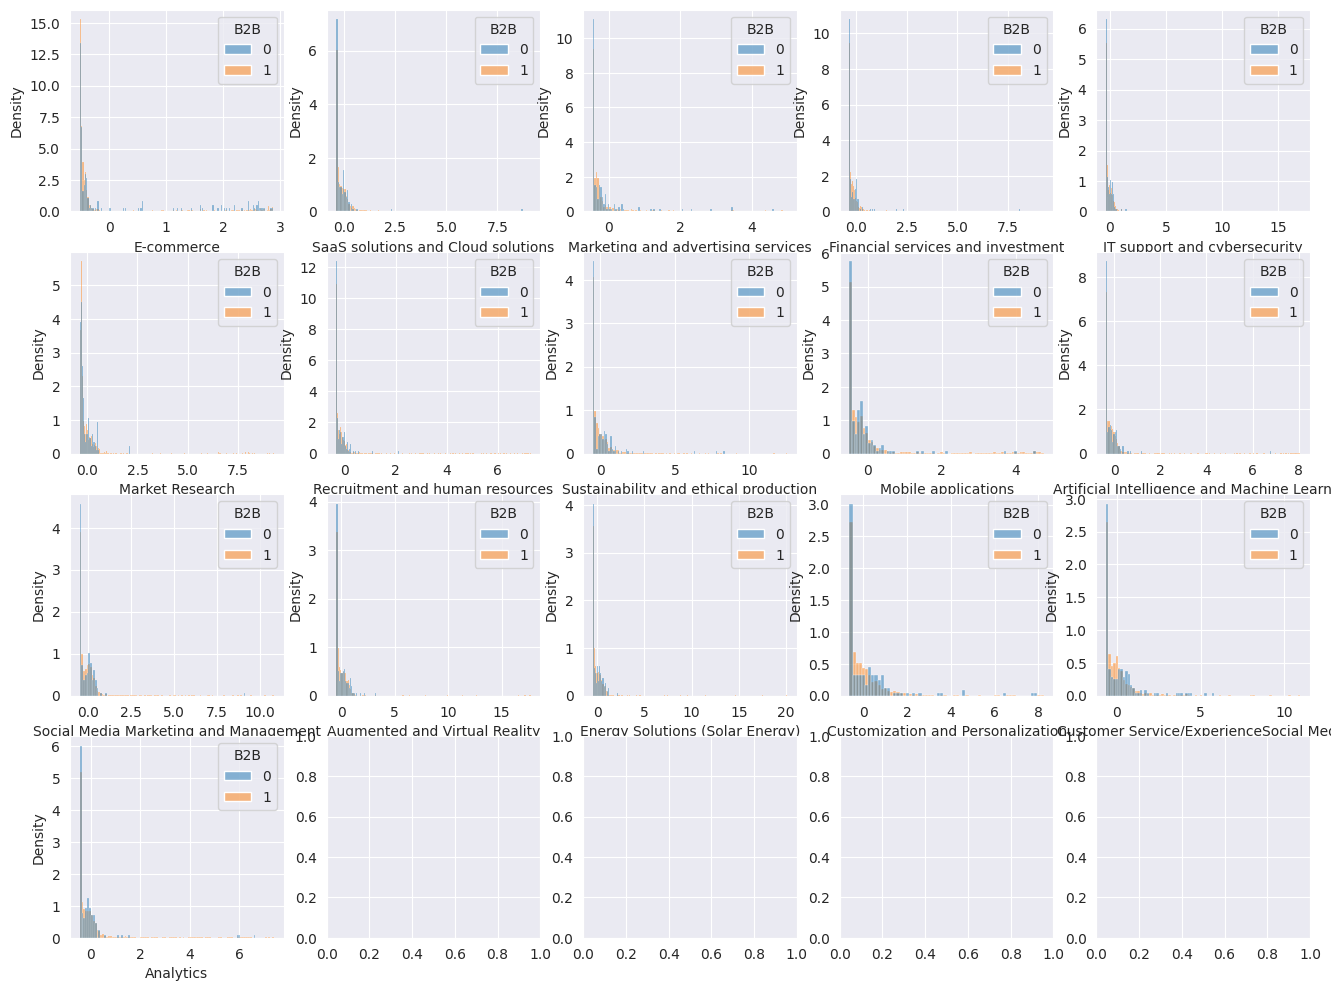

In [114]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(specialty_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

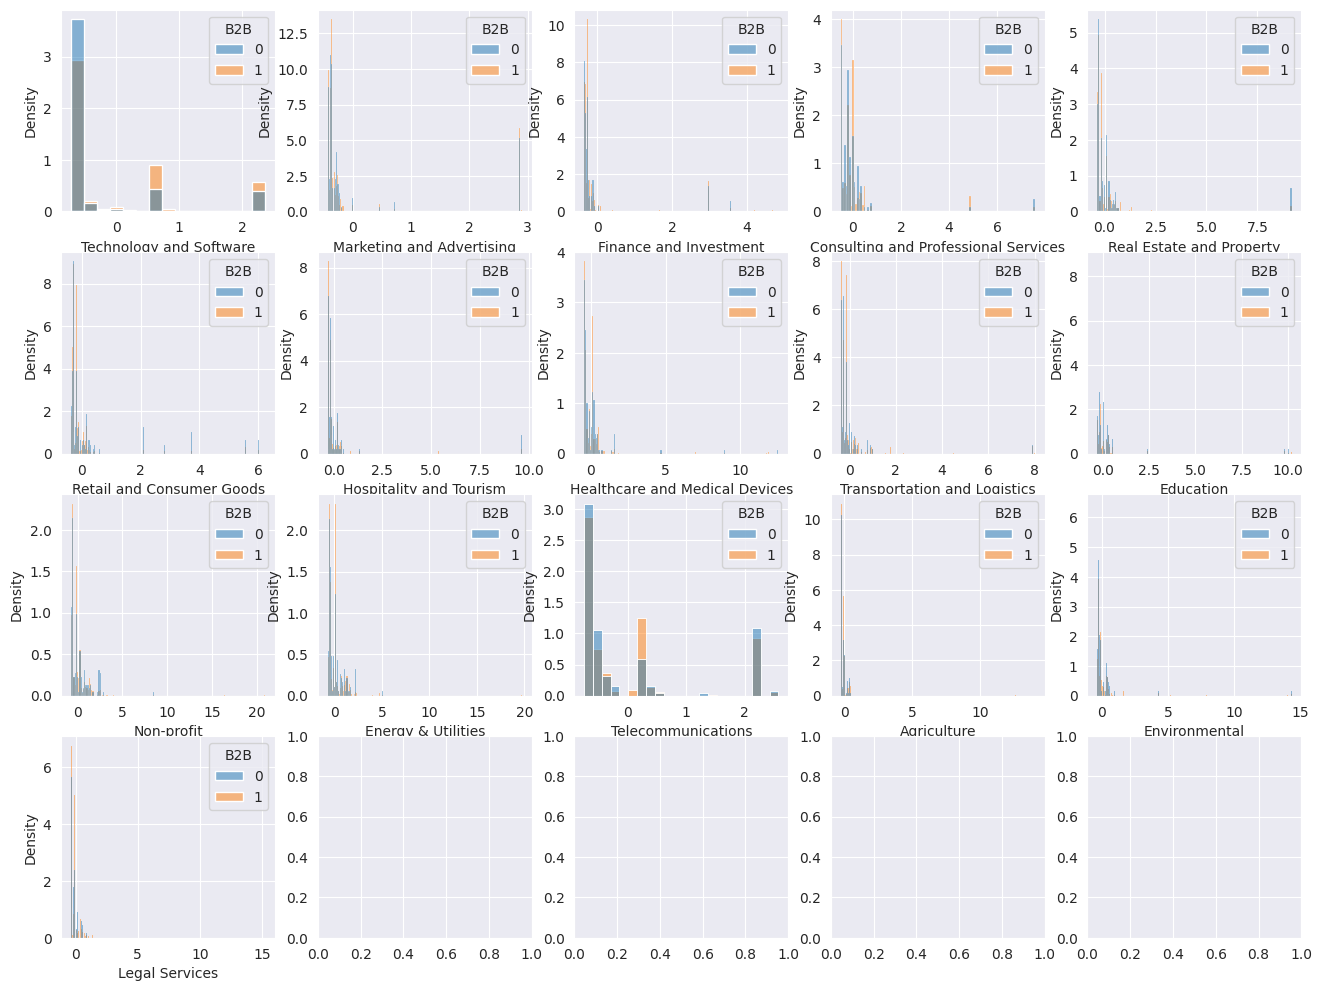

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(industry_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

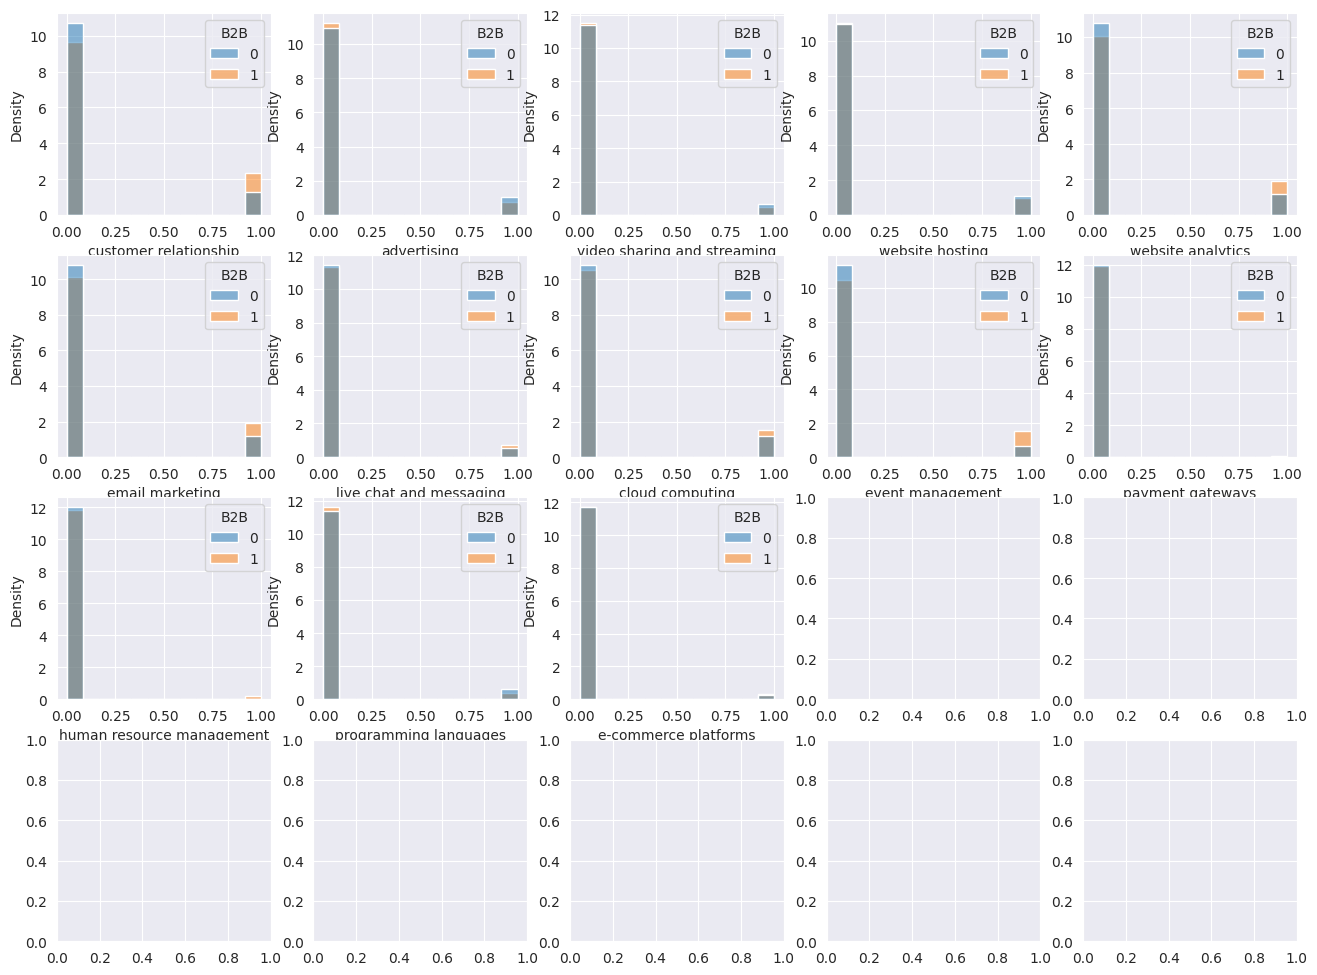

In [116]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(tech_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

In [117]:
df_txt.to_csv('df_txt_scaled.csv')

Here we can attest that the different text extracted features do show some variance according to which label they are assigned to!

# Model Training
---

In [118]:
df_txt.head()

,employees_on_linkedin,followers,founded,industry,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C,Other,Partnership,Privately Held,Public Company,Self Employed,1-10,11-50,201-500,500+,51-200,E-commerce,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Market Research,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics,Software/IT,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Saas,Public Relations,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services,customer relationship,advertising,video sharing and streaming,website hosting,website analytics,email marketing,live chat and messaging,cloud computing,event management,payment gateways,human resource management,programming languages,e-commerce platforms
0,-0.065928,-0.058531,0.507042,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,-0.513158,1.070903,-0.181520,0.107069,0.339716,-0.370127,0.011009,1.062802,-0.194621,0.105379,0.085102,0.110293,0.353926,0.442179,0.564330,0.342751,-0.507173,-0.381493,-0.462018,-0.317242,-0.330725,-0.424860,-0.441664,-0.311660,-0.331533,-0.270690,-0.207979,-0.244662,-0.251657,-0.256176,-0.305881,-0.658030,-0.290331,-0.689798,-0.388720,-0.292652,-0.353712,-0.199373,-0.198775,8.464173,-0.302025,-0.259537,-0.192536,0.229333,-0.314295,-0.690340,-0.071879,-0.101073,-0.148485,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.190220,-0.166734,-0.139792,Staffing and Recruiting,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,-0.506551,-0.074418,-0.206202,0.682485,0.154851,-0.312263,0.437982,-0.040519,0.558653,-0.155725,-0.009749,0.179424,0.545711,0.335804,-0.069470,-0.105664,-0.497307,-0.371482,3.503437,1.264422,-0.318655,-0.398450,-0.420346,-0.260461,-0.311558,-0.249222,-0.192646,-0.225039,-0.227859,-0.234270,-0.272874,-0.593595,-0.249558,-0.564790,-0.281207,-0.144944,0.293283,0.345231,0.263590,0.267596,0.407157,0.166529,0.362060,1.379584,1.221958,-0.386203,0.393885,0.450748,0.772872,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0.045934,-0.094660,0.507042,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,-0.509049,-0.361341,-0.436018,-0.308120,-0.295546,-0.326440,7.046277,-0.456327,-0.456576,-0.166653,-0.434454,-0.378092,-0.374003,-0.572753,-0.600212,-0.385002,-0.497322,-0.373286,-0.438252,2.034763,3.233110,-0.400398,-0.426568,-0.299359,-0.310962,-0.226386,-0.196856,-0.227375,-0.231385,-0.237685,-0.262071,-0.572263,-0.256793,0.653489,-0.370045,-0.269627,-0.027635,-0.165830,-0.197896,-0.148693,0.083521,-0.144735,-0.115452,-0.112451,0.063153,0.232805,-0.071477,-0.116499,-0.084790,0,0,0,0,0,1,0,1,0,0,0,0,0
3,0.493383,1.820885,0.102771,Printing,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,-0.428185,-0.251642,1.494802,-0.224635,-0.111981,-0.239519,-0.214123,-0.271879,-0.296

In [119]:
df_txt.columns

Index(['employees_on_linkedin', 'followers', 'founded', 'industry',
       'specialties', 'total_funding', 'technologies', 'categories', 'type',
       'has_funding', 'has_events', 'has_hubs', 'B2B', 'B2C', 'Other',
       'Partnership', 'Privately Held', 'Public Company', 'Self Employed',
       '1-10', '11-50', '201-500', '500+', '51-200', 'E-commerce',
       'SaaS solutions and Cloud solutions',
       'Marketing and advertising services',
       'Financial services and investment', 'IT support and cybersecurity',
       'Market Research', 'Recruitment and human resources',
       'Sustainability and ethical production', 'Mobile applications',
       'Artificial Intelligence and Machine Learning',
       'Social Media Marketing and Management',
       'Augmented and Virtual Reality', 'Energy Solutions (Solar Energy)',
       'Customization and Personalization',
       'Customer Service/ExperienceSocial Media', 'Analytics', 'Software/IT',
       'Marketing/Advertising', 'Consulting/

In [120]:
df_train = df_txt.drop(columns=['specialties', 'total_funding', 'technologies', 'categories', 'specialties', 'industry']).copy()

In [121]:
df_train.shape

(1781, 81)

### Get X & y

In [168]:
X = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
X_b2c = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
X_b2b = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()

y = df_train[['B2B', 'B2C']]
y_b2c = y['B2C']
y_b2b = y['B2B']

In [123]:
y_b2c.value_counts()

0    1299
1     482
Name: B2C, dtype: int64

In [124]:
y_b2b.value_counts()

1    1612
0     169
Name: B2B, dtype: int64

### Class Imbalance
---

After frustrated attempts to fit the model (that was mostly just predicting one class, B2B, because of its majority on the dataset), I have decided to **undersample** the dataset to better fit the two tasks. There are many ways to deal with **class imbalance** found on a dataset such as this one. This is only a first attempt, with obvious setbacks (the dataset size is way smaller than it was before).

Other methods for dealing with this problem could consist of better evaluation metrics and loss functions, such as AUC, F1 or RECALL, which punish class prediction over a single class more than a simple accuracy score. 


In [125]:
from imblearn.under_sampling import RandomUnderSampler

In [126]:
rus = RandomUnderSampler(random_state=42)
X_b2c_resampled, y_b2c_resampled = rus.fit_resample(X_b2c, y_b2c)

In [127]:
rus = RandomUnderSampler(random_state=42)
X_b2b_resampled, y_b2b_resampled = rus.fit_resample(X_b2b, y_b2b)

In [128]:
y_b2c_resampled.value_counts()

0    482
1    482
Name: B2C, dtype: int64

In [129]:
y_b2b_resampled.value_counts()

0    169
1    169
Name: B2B, dtype: int64

## Model Selection
---

In [182]:
import lightgbm as lgb
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## OPTUNA - Hyperparameter Tuning
---

I have chosen to use OPTUNA as a hyperparameter tuning tool. It takes different hyperparameters for the specified model and attempts to use different combinations of their values in a specific range in order to make better predictions. It is way more optimized than using a simple gridsearch algorithm.

## LightGBM
---
LightGBM is a popular gradient boosting framework that is particularly well-suited for classification tasks due to its high speed, high accuracy, and ability to handle large-scale datasets with high dimensionality. 

All in all it is a State-of-the-art model with fast convergence and very well suited for the task at hand.

## Evaluation
---

In [223]:
def evaluate_model(model_name, best_params, X, y, tipo):

  # split the dataframe into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # print the shapes of the resulting sets
  print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
  print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

  y_train = y_train[tipo]
  y_test = y_test[tipo]

  # Train the XGBoost model using the best hyperparameters
  model = lgb.LGBMClassifier(**best_params, gpu_id=device_id)
  model.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = model.predict(X_test)

  # Convert probabilities to binary labels
  y_pred_binary = y_pred.round().astype(int)

  # Evaluate model performance using metrics like accuracy, precision, recall, F1 score, and AUC-ROC
  accuracy = accuracy_score(y_test, y_pred_binary)
  precision = precision_score(y_test, y_pred_binary, average='weighted')
  recall = recall_score(y_test, y_pred_binary, average='weighted')
  f1 = f1_score(y_test, y_pred_binary, average='weighted')
  auc_roc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 score:", f1)
  print("AUC-ROC:", auc_roc)

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(model_name)
  plt.show()

  # Compute ROC curve and AUC
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()


In [242]:
def objective(trial):

    # X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        'is_unbalance':True,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "num_iterations": trial.suggest_int("num_iterations", 100, 1000),
        "random_state": 42
    }
    
    # Train and evaluate the model
    model = lgb.train(params, lgb.Dataset(X_train, label=y_train), valid_sets=[lgb.Dataset(X_test, label=y_test)], verbose_eval=False)
    y_pred = model.predict(X_test)
    y_pred_binary = y_pred.round().astype(int)


    # Evaluate model performance using metrics like accuracy, precision, recall, F1 score, and AUC-ROC
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='weighted')
    recall = recall_score(y_test, y_pred_binary, average='weighted')
    f1 = f1_score(y_test, y_pred_binary, average='weighted')
    auc_roc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    # return 1.0 - f1

    return accuracy

## B2C MODEL

[I 2023-04-03 20:59:43,003] A new study created in memory with name: no-name-5f0b2367-37f6-4dc3-bb2b-eaf555884f74


Shape of X_b2c = (1781, 78), y_b2c = (1781,)
Shape of X_b2c_resampled = (964, 78), y_b2c_resampled = (964,)
Training set shape: X_train = (1424, 78), y_train = (1424,)
Testing set shape: X_test = (357, 78), y_test = (357,)
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=79


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 20:59:44,398] Trial 0 finished with value: 0.711484593837535 and parameters: {'lambda_l1': 2.5419298670676596, 'lambda_l2': 4.667094040945144, 'num_leaves': 252, 'learning_rate': 0.2677595161614736, 'feature_fraction': 0.7216372713776872, 'bagging_fraction': 0.5696268269422454, 'bagging_freq': 2, 'min_child_samples': 24, 'min_data_in_leaf': 79, 'max_depth': 11, 'num_iterations': 564}. Best is trial 0 with value: 0.71148

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=80


[I 2023-04-03 20:59:46,303] Trial 1 finished with value: 0.7507002801120448 and parameters: {'lambda_l1': 3.916076042565392, 'lambda_l2': 3.068819762469739, 'num_leaves': 32, 'learning_rate': 0.07343820338766312, 'feature_fraction': 0.5813464682009042, 'bagging_fraction': 0.8199747651779353, 'bagging_freq': 4, 'min_child_samples': 16, 'min_data_in_leaf': 80, 'max_depth': 29, 'num_iterations': 617}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=51


[I 2023-04-03 20:59:46,794] Trial 2 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 5.990908770113589, 'lambda_l2': 4.430634299145075, 'num_leaves': 180, 'learning_rate': 0.6845035044237232, 'feature_fraction': 0.3804015534315216, 'bagging_fraction': 0.45543083148340446, 'bagging_freq': 3, 'min_child_samples': 46, 'min_data_in_leaf': 51, 'max_depth': 16, 'num_iterations': 270}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-03 20:59:47,585] Trial 3 finished with value: 0.6890756302521008 and parameters: {'lambda_l1': 4.866809066453761, 'lambda_l2': 8.246679878230827, 'num_leaves': 239, 'learning_rate': 0.2595484359066347, 'feature_fraction': 0.3007647003130757, 'bagging_fraction': 0.22990148525364068, 'bagging_freq': 2, 'min_child_samples': 72, 'min_data_in_leaf': 22, 'max_depth': 10, 'num_iterations': 446}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=98


[I 2023-04-03 20:59:47,904] Trial 4 finished with value: 0.5938375350140056 and parameters: {'lambda_l1': 2.456860304239372, 'lambda_l2': 1.469037892576877, 'num_leaves': 44, 'learning_rate': 0.33624726125939813, 'feature_fraction': 0.4737752357873518, 'bagging_fraction': 0.15540176901453379, 'bagging_freq': 7, 'min_child_samples': 69, 'min_data_in_leaf': 98, 'max_depth': 29, 'num_iterations': 428}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=84


[I 2023-04-03 20:59:48,202] Trial 5 finished with value: 0.6498599439775911 and parameters: {'lambda_l1': 0.8812103467556492, 'lambda_l2': 4.059549902951171, 'num_leaves': 106, 'learning_rate': 0.9526096342230829, 'feature_fraction': 0.9975871273897141, 'bagging_fraction': 0.26812003897820746, 'bagging_freq': 3, 'min_child_samples': 10, 'min_data_in_leaf': 84, 'max_depth': 15, 'num_iterations': 174}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=100


[I 2023-04-03 20:59:48,937] Trial 6 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 1.3647689961362246, 'lambda_l2': 9.019790454701843, 'num_leaves': 161, 'learning_rate': 0.72306616018838, 'feature_fraction': 0.17729622569681933, 'bagging_fraction': 0.8424596640617255, 'bagging_freq': 6, 'min_child_samples': 52, 'min_data_in_leaf': 100, 'max_depth': 13, 'num_iterations': 479}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=68


[I 2023-04-03 20:59:49,691] Trial 7 finished with value: 0.7198879551820728 and parameters: {'lambda_l1': 3.3209150381018024, 'lambda_l2': 0.8256054722512484, 'num_leaves': 68, 'learning_rate': 0.25946671015500045, 'feature_fraction': 0.9262735502266962, 'bagging_fraction': 0.7890643869086856, 'bagging_freq': 4, 'min_child_samples': 14, 'min_data_in_leaf': 68, 'max_depth': 7, 'num_iterations': 193}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=71


[I 2023-04-03 20:59:50,170] Trial 8 finished with value: 0.6946778711484594 and parameters: {'lambda_l1': 7.048594531360663, 'lambda_l2': 0.8721931960310986, 'num_leaves': 163, 'learning_rate': 0.854229046392733, 'feature_fraction': 0.3777551288423827, 'bagging_fraction': 0.19859293298966424, 'bagging_freq': 6, 'min_child_samples': 14, 'min_data_in_leaf': 71, 'max_depth': 28, 'num_iterations': 447}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-03 20:59:50,839] Trial 9 finished with value: 0.6834733893557423 and parameters: {'lambda_l1': 8.360987623908406, 'lambda_l2': 1.278839809103865, 'num_leaves': 23, 'learning_rate': 0.24004982703166222, 'feature_fraction': 0.8707286129801648, 'bagging_fraction': 0.16139717430838768, 'bagging_freq': 3, 'min_child_samples': 34, 'min_data_in_leaf': 21, 'max_depth': 9, 'num_iterations': 515}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 20:59:53,793] Trial 10 finished with value: 0.7310924369747899 and parameters: {'lambda_l1': 9.157397854193528, 'lambda_l2': 6.66063737062168, 'num_leaves': 87, 'learning_rate': 0.0188566589900966, 'feature_fraction': 0.6285093930485075, 'bagging_fraction': 0.9963167754410996, 'bagging_freq': 5, 'min_child_samples': 98, 'min_data_in_leaf': 48, 'max_depth': 23, 'num_iterations': 971}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 20:59:55,757] Trial 11 finished with value: 0.7086834733893558 and parameters: {'lambda_l1': 9.914926098489609, 'lambda_l2': 6.792375161092372, 'num_leaves': 94, 'learning_rate': 0.0016204415699550244, 'feature_fraction': 0.6128123231039367, 'bagging_fraction': 0.9667255251700839, 'bagging_freq': 5, 'min_child_samples': 94, 'min_data_in_leaf': 48, 'max_depth': 22, 'num_iterations': 967}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=37


[I 2023-04-03 20:59:57,457] Trial 12 finished with value: 0.6750700280112045 and parameters: {'lambda_l1': 4.792208801778819, 'lambda_l2': 6.525201809495859, 'num_leaves': 6, 'learning_rate': 0.003105272128531393, 'feature_fraction': 0.6062529579622424, 'bagging_fraction': 0.9516087162131088, 'bagging_freq': 5, 'min_child_samples': 98, 'min_data_in_leaf': 37, 'max_depth': 23, 'num_iterations': 968}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=62


[I 2023-04-03 20:59:58,182] Trial 13 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 9.862445957873714, 'lambda_l2': 2.9284518705846456, 'num_leaves': 67, 'learning_rate': 0.10203968266466446, 'feature_fraction': 0.750276181952136, 'bagging_fraction': 0.7739983878786323, 'bagging_freq': 4, 'min_child_samples': 74, 'min_data_in_leaf': 62, 'max_depth': 23, 'num_iterations': 758}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=69


[I 2023-04-03 20:59:58,774] Trial 14 finished with value: 0.6974789915966386 and parameters: {'lambda_l1': 7.721688422772019, 'lambda_l2': 2.959731728612864, 'num_leaves': 49, 'learning_rate': 0.45687825207977634, 'feature_fraction': 0.7770543451112264, 'bagging_fraction': 0.7317806129020269, 'bagging_freq': 1, 'min_child_samples': 75, 'min_data_in_leaf': 69, 'max_depth': 26, 'num_iterations': 735}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=8


[I 2023-04-03 20:59:59,475] Trial 15 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 6.700453596201247, 'lambda_l2': 2.706647846339335, 'num_leaves': 131, 'learning_rate': 0.14276598537719812, 'feature_fraction': 0.7341899995416962, 'bagging_fraction': 0.6344862286695829, 'bagging_freq': 4, 'min_child_samples': 64, 'min_data_in_leaf': 8, 'max_depth': 20, 'num_iterations': 732}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=86


[I 2023-04-03 21:00:00,167] Trial 16 finished with value: 0.7198879551820728 and parameters: {'lambda_l1': 8.678803285385802, 'lambda_l2': 0.02293784082339112, 'num_leaves': 41, 'learning_rate': 0.13185017259252038, 'feature_fraction': 0.5229744984123569, 'bagging_fraction': 0.6903356045935014, 'bagging_freq': 4, 'min_child_samples': 83, 'min_data_in_leaf': 86, 'max_depth': 30, 'num_iterations': 733}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=61


[I 2023-04-03 21:00:00,643] Trial 17 finished with value: 0.7366946778711485 and parameters: {'lambda_l1': 3.983928609276262, 'lambda_l2': 2.9425123572279803, 'num_leaves': 122, 'learning_rate': 0.46306334464677923, 'feature_fraction': 0.8360882608181209, 'bagging_fraction': 0.8564265492936117, 'bagging_freq': 6, 'min_child_samples': 43, 'min_data_in_leaf': 61, 'max_depth': 19, 'num_iterations': 629}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=59


[I 2023-04-03 21:00:01,605] Trial 18 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 5.873291475411042, 'lambda_l2': 5.52636782467169, 'num_leaves': 6, 'learning_rate': 0.15270946205396208, 'feature_fraction': 0.6832429603161045, 'bagging_fraction': 0.7892285954201451, 'bagging_freq': 2, 'min_child_samples': 59, 'min_data_in_leaf': 59, 'max_depth': 26, 'num_iterations': 867}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=37


[I 2023-04-03 21:00:02,115] Trial 19 finished with value: 0.7254901960784313 and parameters: {'lambda_l1': 7.794924407424325, 'lambda_l2': 2.029598163480514, 'num_leaves': 68, 'learning_rate': 0.3519626219819989, 'feature_fraction': 0.5319087835180324, 'bagging_fraction': 0.6330677174938221, 'bagging_freq': 3, 'min_child_samples': 31, 'min_data_in_leaf': 37, 'max_depth': 4, 'num_iterations': 847}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=78


[I 2023-04-03 21:00:02,980] Trial 20 finished with value: 0.7002801120448179 and parameters: {'lambda_l1': 9.365883148374186, 'lambda_l2': 3.6321829749880212, 'num_leaves': 70, 'learning_rate': 0.13015615721409218, 'feature_fraction': 0.7660825270580213, 'bagging_fraction': 0.4919642859963997, 'bagging_freq': 4, 'min_child_samples': 85, 'min_data_in_leaf': 78, 'max_depth': 25, 'num_iterations': 624}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=62


[I 2023-04-03 21:00:03,773] Trial 21 finished with value: 0.7366946778711485 and parameters: {'lambda_l1': 4.163473778226444, 'lambda_l2': 2.9926472882028223, 'num_leaves': 130, 'learning_rate': 0.49078469860832225, 'feature_fraction': 0.8220826133691537, 'bagging_fraction': 0.8775912180645447, 'bagging_freq': 7, 'min_child_samples': 42, 'min_data_in_leaf': 62, 'max_depth': 19, 'num_iterations': 631}. Best is trial 1 with value: 0.7507002801120448.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=59


[I 2023-04-03 21:00:04,592] Trial 22 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 3.835782698803895, 'lambda_l2': 2.1592655263491096, 'num_leaves': 115, 'learning_rate': 0.3908512551542622, 'feature_fraction': 0.8532043078411724, 'bagging_fraction': 0.884157403950447, 'bagging_freq': 6, 'min_child_samples': 22, 'min_data_in_leaf': 59, 'max_depth': 19, 'num_iterations': 664}. Best is trial 22 with value: 0.7535014005602241.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=90


[I 2023-04-03 21:00:05,227] Trial 23 finished with value: 0.7002801120448179 and parameters: {'lambda_l1': 5.610846241525686, 'lambda_l2': 1.8355750991492865, 'num_leaves': 29, 'learning_rate': 0.38841648420393604, 'feature_fraction': 0.6722523760504092, 'bagging_fraction': 0.7535257541511192, 'bagging_freq': 5, 'min_child_samples': 21, 'min_data_in_leaf': 90, 'max_depth': 20, 'num_iterations': 342}. Best is trial 22 with value: 0.7535014005602241.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=41


[I 2023-04-03 21:00:06,086] Trial 24 finished with value: 0.7366946778711485 and parameters: {'lambda_l1': 3.72302135914754, 'lambda_l2': 3.651076935084071, 'num_leaves': 209, 'learning_rate': 0.5953759296426491, 'feature_fraction': 0.9040887609127355, 'bagging_fraction': 0.9015704649215792, 'bagging_freq': 4, 'min_child_samples': 26, 'min_data_in_leaf': 41, 'max_depth': 27, 'num_iterations': 810}. Best is trial 22 with value: 0.7535014005602241.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=75


[I 2023-04-03 21:00:09,304] Trial 25 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 0.1301905680182669, 'lambda_l2': 2.263404311239792, 'num_leaves': 86, 'learning_rate': 0.08320376754185273, 'feature_fraction': 0.7772942512916582, 'bagging_fraction': 0.823407967464095, 'bagging_freq': 6, 'min_child_samples': 9, 'min_data_in_leaf': 75, 'max_depth': 17, 'num_iterations': 688}. Best is trial 22 with value: 0.7535014005602241.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=59


[I 2023-04-03 21:00:11,142] Trial 26 finished with value: 0.7591036414565826 and parameters: {'lambda_l1': 5.285825294020865, 'lambda_l2': 3.3899479580345906, 'num_leaves': 108, 'learning_rate': 0.17689633542303512, 'feature_fraction': 0.6790245198779505, 'bagging_fraction': 0.923422286117185, 'bagging_freq': 5, 'min_child_samples': 35, 'min_data_in_leaf': 59, 'max_depth': 23, 'num_iterations': 573}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=56


[I 2023-04-03 21:00:12,448] Trial 27 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.729166058603041, 'lambda_l2': 3.59219794322028, 'num_leaves': 144, 'learning_rate': 0.21454326410223362, 'feature_fraction': 0.6633425730727334, 'bagging_fraction': 0.9120017334350823, 'bagging_freq': 5, 'min_child_samples': 19, 'min_data_in_leaf': 56, 'max_depth': 25, 'num_iterations': 558}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=91


[I 2023-04-03 21:00:13,407] Trial 28 finished with value: 0.7310924369747899 and parameters: {'lambda_l1': 3.1361672512563183, 'lambda_l2': 5.120386940019135, 'num_leaves': 114, 'learning_rate': 0.19607561791110892, 'feature_fraction': 0.6118149841911882, 'bagging_fraction': 0.9198099640894222, 'bagging_freq': 7, 'min_child_samples': 34, 'min_data_in_leaf': 91, 'max_depth': 21, 'num_iterations': 385}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=81


[I 2023-04-03 21:00:14,340] Trial 29 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 2.6641401363125183, 'lambda_l2': 4.671274338800781, 'num_leaves': 200, 'learning_rate': 0.31020948357298583, 'feature_fraction': 0.7099016305605106, 'bagging_fraction': 0.9439708493102937, 'bagging_freq': 6, 'min_child_samples': 28, 'min_data_in_leaf': 81, 'max_depth': 14, 'num_iterations': 570}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 21:00:15,091] Trial 30 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.247132310925871, 'lambda_l2': 2.0939055986778934, 'num_leaves': 158, 'learning_rate': 0.3892972354290831, 'feature_fraction': 0.8179590013071105, 'bagging_fraction': 0.984263563344462, 'bagging_freq': 5, 'min_child_samples': 39, 'min_data_in_leaf': 43, 'max_depth': 18, 'num_iterations': 590}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=80


[I 2023-04-03 21:00:16,005] Trial 31 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 2.5228205364226803, 'lambda_l2': 4.723559040555815, 'num_leaves': 255, 'learning_rate': 0.3085231122163714, 'feature_fraction': 0.7064894933134903, 'bagging_fraction': 0.9003597585559471, 'bagging_freq': 6, 'min_child_samples': 24, 'min_data_in_leaf': 80, 'max_depth': 13, 'num_iterations': 519}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2023-04-03 21:00:17,236] Trial 32 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 2.4515935294792643, 'lambda_l2': 4.483327453966609, 'num_leaves': 239, 'learning_rate': 0.2957995600022517, 'feature_fraction': 0.6911752041865911, 'bagging_fraction': 0.8312855798503301, 'bagging_freq': 6, 'min_child_samples': 20, 'min_data_in_leaf': 73, 'max_depth': 13, 'num_iterations': 511}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=67


[I 2023-04-03 21:00:18,708] Trial 33 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 5.2756101387907055, 'lambda_l2': 4.289970384135308, 'num_leaves': 228, 'learning_rate': 0.20202032671651365, 'feature_fraction': 0.5778324422661894, 'bagging_fraction': 0.8545401697724344, 'bagging_freq': 7, 'min_child_samples': 6, 'min_data_in_leaf': 67, 'max_depth': 11, 'num_iterations': 661}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=53


[I 2023-04-03 21:00:19,545] Trial 34 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 4.531802246031142, 'lambda_l2': 3.760430302578329, 'num_leaves': 177, 'learning_rate': 0.2665294034702528, 'feature_fraction': 0.49367363805649944, 'bagging_fraction': 0.8465549590515149, 'bagging_freq': 5, 'min_child_samples': 17, 'min_data_in_leaf': 53, 'max_depth': 16, 'num_iterations': 325}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=76


[I 2023-04-03 21:00:20,996] Trial 35 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 5.124077941614407, 'lambda_l2': 2.4928985208467678, 'num_leaves': 103, 'learning_rate': 0.06969006895500922, 'feature_fraction': 0.5643709031369414, 'bagging_fraction': 0.7136027605513297, 'bagging_freq': 6, 'min_child_samples': 36, 'min_data_in_leaf': 76, 'max_depth': 28, 'num_iterations': 496}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=94


[I 2023-04-03 21:00:23,575] Trial 36 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 1.836467290227207, 'lambda_l2': 4.197463216667875, 'num_leaves': 144, 'learning_rate': 0.18165676965954158, 'feature_fraction': 0.660925437755283, 'bagging_fraction': 0.8070581889729819, 'bagging_freq': 7, 'min_child_samples': 23, 'min_data_in_leaf': 94, 'max_depth': 11, 'num_iterations': 681}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=73


[I 2023-04-03 21:00:24,285] Trial 37 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 3.5274536647146775, 'lambda_l2': 3.303447253318038, 'num_leaves': 192, 'learning_rate': 0.25772463119835365, 'feature_fraction': 0.4527308019659339, 'bagging_fraction': 0.8867881776889573, 'bagging_freq': 6, 'min_child_samples': 50, 'min_data_in_leaf': 73, 'max_depth': 30, 'num_iterations': 106}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=65


[I 2023-04-03 21:00:26,061] Trial 38 finished with value: 0.7254901960784313 and parameters: {'lambda_l1': 3.2378961365311243, 'lambda_l2': 3.2582729923270226, 'num_leaves': 237, 'learning_rate': 0.3004167806828877, 'feature_fraction': 0.9402928549100867, 'bagging_fraction': 0.8139519096175162, 'bagging_freq': 5, 'min_child_samples': 13, 'min_data_in_leaf': 65, 'max_depth': 15, 'num_iterations': 418}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=50


[I 2023-04-03 21:00:27,289] Trial 39 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 2.0262823154648593, 'lambda_l2': 2.4412235018225434, 'num_leaves': 219, 'learning_rate': 0.36885376434402556, 'feature_fraction': 0.720586913133401, 'bagging_fraction': 0.9390884131539201, 'bagging_freq': 1, 'min_child_samples': 28, 'min_data_in_leaf': 50, 'max_depth': 8, 'num_iterations': 466}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=29


[I 2023-04-03 21:00:28,001] Trial 40 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 1.802983512760854, 'lambda_l2': 1.5707328704318972, 'num_leaves': 177, 'learning_rate': 0.4017560047288199, 'feature_fraction': 0.999828580796102, 'bagging_fraction': 0.9975350913623271, 'bagging_freq': 1, 'min_child_samples': 29, 'min_data_in_leaf': 29, 'max_depth': 3, 'num_iterations': 273}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 21:00:28,824] Trial 41 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 2.9138673153414185, 'lambda_l2': 2.3879850709691994, 'num_leaves': 220, 'learning_rate': 0.3448752053644691, 'feature_fraction': 0.7305316224949242, 'bagging_fraction': 0.9483638967519457, 'bagging_freq': 2, 'min_child_samples': 5, 'min_data_in_leaf': 54, 'max_depth': 7, 'num_iterations': 535}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=50


[I 2023-04-03 21:00:29,866] Trial 42 finished with value: 0.7310924369747899 and parameters: {'lambda_l1': 2.323541948623264, 'lambda_l2': 3.9353541213375864, 'num_leaves': 241, 'learning_rate': 0.2266641016808115, 'feature_fraction': 0.6487008814428287, 'bagging_fraction': 0.8689657390438567, 'bagging_freq': 3, 'min_child_samples': 17, 'min_data_in_leaf': 50, 'max_depth': 7, 'num_iterations': 484}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=58


[I 2023-04-03 21:00:30,775] Trial 43 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 3.757355096912026, 'lambda_l2': 2.516484794597488, 'num_leaves': 219, 'learning_rate': 0.29059449409060684, 'feature_fraction': 0.7091603000202379, 'bagging_fraction': 0.9346439630313159, 'bagging_freq': 1, 'min_child_samples': 12, 'min_data_in_leaf': 58, 'max_depth': 13, 'num_iterations': 461}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=45


[I 2023-04-03 21:00:31,870] Trial 44 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 3.5186802214316155, 'lambda_l2': 0.9753684225208472, 'num_leaves': 243, 'learning_rate': 0.1775169640678006, 'feature_fraction': 0.5902285856924179, 'bagging_fraction': 0.8348178439484697, 'bagging_freq': 2, 'min_child_samples': 48, 'min_data_in_leaf': 45, 'max_depth': 9, 'num_iterations': 599}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=65


[I 2023-04-03 21:00:32,588] Trial 45 finished with value: 0.7507002801120448 and parameters: {'lambda_l1': 4.340180482962573, 'lambda_l2': 1.9961853133207215, 'num_leaves': 147, 'learning_rate': 0.24653307304939112, 'feature_fraction': 0.8100821501248596, 'bagging_fraction': 0.9558800747981838, 'bagging_freq': 6, 'min_child_samples': 32, 'min_data_in_leaf': 65, 'max_depth': 5, 'num_iterations': 389}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=63


[I 2023-04-03 21:00:33,839] Trial 46 finished with value: 0.7254901960784313 and parameters: {'lambda_l1': 4.375364500190919, 'lambda_l2': 1.6298430898752103, 'num_leaves': 151, 'learning_rate': 0.05495409327702307, 'feature_fraction': 0.8830509886062055, 'bagging_fraction': 0.998515132591638, 'bagging_freq': 7, 'min_child_samples': 32, 'min_data_in_leaf': 63, 'max_depth': 5, 'num_iterations': 364}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=68


[I 2023-04-03 21:00:34,543] Trial 47 finished with value: 0.7507002801120448 and parameters: {'lambda_l1': 5.3212084816620155, 'lambda_l2': 1.313654945404756, 'num_leaves': 94, 'learning_rate': 0.24906598325940055, 'feature_fraction': 0.7927552946173722, 'bagging_fraction': 0.9571426773710959, 'bagging_freq': 5, 'min_child_samples': 38, 'min_data_in_leaf': 68, 'max_depth': 5, 'num_iterations': 411}. Best is trial 26 with value: 0.7591036414565826.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=33


[I 2023-04-03 21:00:35,122] Trial 48 finished with value: 0.7619047619047619 and parameters: {'lambda_l1': 4.768115548905071, 'lambda_l2': 1.9676247789817762, 'num_leaves': 114, 'learning_rate': 0.5355439476824558, 'feature_fraction': 0.8415021111115882, 'bagging_fraction': 0.9296372542156885, 'bagging_freq': 3, 'min_child_samples': 57, 'min_data_in_leaf': 33, 'max_depth': 8, 'num_iterations': 292}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 21:00:35,607] Trial 49 finished with value: 0.7030812324929971 and parameters: {'lambda_l1': 6.178299533335094, 'lambda_l2': 2.523181188746995, 'num_leaves': 55, 'learning_rate': 0.5650774009386053, 'feature_fraction': 0.856812105272156, 'bagging_fraction': 0.9057365375812952, 'bagging_freq': 3, 'min_child_samples': 59, 'min_data_in_leaf': 27, 'max_depth': 9, 'num_iterations': 239}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=15


[I 2023-04-03 21:00:36,188] Trial 50 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.85262583457378, 'lambda_l2': 3.282562939735315, 'num_leaves': 114, 'learning_rate': 0.4302211111928299, 'feature_fraction': 0.9409723717265961, 'bagging_fraction': 0.799050447883821, 'bagging_freq': 4, 'min_child_samples': 58, 'min_data_in_leaf': 15, 'max_depth': 22, 'num_iterations': 162}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-03 21:00:36,753] Trial 51 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 4.188362358078068, 'lambda_l2': 2.10717288436413, 'num_leaves': 83, 'learning_rate': 0.535939698972581, 'feature_fraction': 0.7998026412608007, 'bagging_fraction': 0.9600233711253975, 'bagging_freq': 3, 'min_child_samples': 44, 'min_data_in_leaf': 32, 'max_depth': 6, 'num_iterations': 313}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of L

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=37


[I 2023-04-03 21:00:37,566] Trial 52 finished with value: 0.7226890756302521 and parameters: {'lambda_l1': 3.924967403199508, 'lambda_l2': 1.785260479729564, 'num_leaves': 104, 'learning_rate': 0.525952242645433, 'feature_fraction': 0.7516888330411765, 'bagging_fraction': 0.9214083795669878, 'bagging_freq': 3, 'min_child_samples': 44, 'min_data_in_leaf': 37, 'max_depth': 8, 'num_iterations': 282}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-03 21:00:38,632] Trial 53 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 4.890297441794341, 'lambda_l2': 1.1220321293995805, 'num_leaves': 80, 'learning_rate': 0.6257474339140542, 'feature_fraction': 0.8541429620298224, 'bagging_fraction': 0.8767697757228602, 'bagging_freq': 1, 'min_child_samples': 52, 'min_data_in_leaf': 31, 'max_depth': 6, 'num_iterations': 230}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=19


[I 2023-04-03 21:00:39,195] Trial 54 finished with value: 0.7226890756302521 and parameters: {'lambda_l1': 3.8995703951145435, 'lambda_l2': 0.5957744108000194, 'num_leaves': 118, 'learning_rate': 0.5144811323921858, 'feature_fraction': 0.7636595755326406, 'bagging_fraction': 0.9753001905996319, 'bagging_freq': 2, 'min_child_samples': 47, 'min_data_in_leaf': 19, 'max_depth': 10, 'num_iterations': 331}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=33


[I 2023-04-03 21:00:39,849] Trial 55 finished with value: 0.7198879551820728 and parameters: {'lambda_l1': 4.675718851153082, 'lambda_l2': 2.72387697976727, 'num_leaves': 136, 'learning_rate': 0.4240234747286473, 'feature_fraction': 0.7980830349730532, 'bagging_fraction': 0.779280033934655, 'bagging_freq': 3, 'min_child_samples': 55, 'min_data_in_leaf': 33, 'max_depth': 25, 'num_iterations': 297}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=24


[I 2023-04-03 21:00:40,486] Trial 56 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 3.3938444177673768, 'lambda_l2': 2.2483994705420103, 'num_leaves': 58, 'learning_rate': 0.45311922561290247, 'feature_fraction': 0.6421638927251339, 'bagging_fraction': 0.9284925229314487, 'bagging_freq': 4, 'min_child_samples': 70, 'min_data_in_leaf': 24, 'max_depth': 17, 'num_iterations': 444}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=46


[I 2023-04-03 21:00:41,270] Trial 57 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 5.452161275918439, 'lambda_l2': 1.4193398053021278, 'num_leaves': 30, 'learning_rate': 0.4905895288444734, 'feature_fraction': 0.8361463926113596, 'bagging_fraction': 0.8743220763854369, 'bagging_freq': 4, 'min_child_samples': 39, 'min_data_in_leaf': 46, 'max_depth': 3, 'num_iterations': 662}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=7


[I 2023-04-03 21:00:41,920] Trial 58 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 4.169505436755064, 'lambda_l2': 1.9294400563412428, 'num_leaves': 17, 'learning_rate': 0.35368198084823244, 'feature_fraction': 0.7436115831449257, 'bagging_fraction': 0.756833631921537, 'bagging_freq': 3, 'min_child_samples': 66, 'min_data_in_leaf': 7, 'max_depth': 8, 'num_iterations': 773}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=41


[I 2023-04-03 21:00:42,718] Trial 59 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 5.833797426771114, 'lambda_l2': 2.8351651820951815, 'num_leaves': 78, 'learning_rate': 0.04160963412248798, 'feature_fraction': 0.9003454722474468, 'bagging_fraction': 0.9762326467004201, 'bagging_freq': 2, 'min_child_samples': 28, 'min_data_in_leaf': 41, 'max_depth': 24, 'num_iterations': 235}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-03 21:00:43,512] Trial 60 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 5.031964023403224, 'lambda_l2': 3.0594720273261684, 'num_leaves': 94, 'learning_rate': 0.10579051258599273, 'feature_fraction': 0.6132263837616413, 'bagging_fraction': 0.892469592330765, 'bagging_freq': 3, 'min_child_samples': 25, 'min_data_in_leaf': 34, 'max_depth': 28, 'num_iterations': 578}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=36


[I 2023-04-03 21:00:44,316] Trial 61 finished with value: 0.7563025210084033 and parameters: {'lambda_l1': 5.043545294756904, 'lambda_l2': 3.187891604796019, 'num_leaves': 98, 'learning_rate': 0.10516966349036616, 'feature_fraction': 0.624773535792575, 'bagging_fraction': 0.8969533572938705, 'bagging_freq': 3, 'min_child_samples': 25, 'min_data_in_leaf': 36, 'max_depth': 29, 'num_iterations': 707}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-03 21:00:46,037] Trial 62 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 5.053943885785022, 'lambda_l2': 2.7358189113919638, 'num_leaves': 95, 'learning_rate': 0.028051078925740783, 'feature_fraction': 0.6236434036311485, 'bagging_fraction': 0.8924223514719241, 'bagging_freq': 3, 'min_child_samples': 25, 'min_data_in_leaf': 32, 'max_depth': 29, 'num_iterations': 715}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=35


[I 2023-04-03 21:00:46,877] Trial 63 finished with value: 0.7507002801120448 and parameters: {'lambda_l1': 4.596339197589326, 'lambda_l2': 3.2168742897283646, 'num_leaves': 125, 'learning_rate': 0.1148911493622399, 'feature_fraction': 0.6763564460646077, 'bagging_fraction': 0.9269594810056642, 'bagging_freq': 2, 'min_child_samples': 34, 'min_data_in_leaf': 35, 'max_depth': 26, 'num_iterations': 582}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=40


[I 2023-04-03 21:00:47,827] Trial 64 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 5.687781846729069, 'lambda_l2': 2.316197752716647, 'num_leaves': 101, 'learning_rate': 0.07813933076209001, 'feature_fraction': 0.7223261025594435, 'bagging_fraction': 0.9652433417709523, 'bagging_freq': 3, 'min_child_samples': 41, 'min_data_in_leaf': 40, 'max_depth': 28, 'num_iterations': 776}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 21:00:48,457] Trial 65 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 6.170907279203145, 'lambda_l2': 3.5162810135839146, 'num_leaves': 113, 'learning_rate': 0.17510366233798227, 'feature_fraction': 0.773038256285541, 'bagging_fraction': 0.8515967584707065, 'bagging_freq': 4, 'min_child_samples': 21, 'min_data_in_leaf': 27, 'max_depth': 29, 'num_iterations': 642}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=51


[I 2023-04-03 21:00:49,227] Trial 66 finished with value: 0.7254901960784313 and parameters: {'lambda_l1': 5.147826064041083, 'lambda_l2': 3.040548412702286, 'num_leaves': 85, 'learning_rate': 0.1428137112397548, 'feature_fraction': 0.6118742005663302, 'bagging_fraction': 0.9000899457742061, 'bagging_freq': 3, 'min_child_samples': 29, 'min_data_in_leaf': 51, 'max_depth': 27, 'num_iterations': 549}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=19


[I 2023-04-03 21:00:50,004] Trial 67 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 5.431184554455198, 'lambda_l2': 1.7852908801554248, 'num_leaves': 75, 'learning_rate': 0.10315387112854307, 'feature_fraction': 0.6391017461348665, 'bagging_fraction': 0.938872030549422, 'bagging_freq': 2, 'min_child_samples': 45, 'min_data_in_leaf': 19, 'max_depth': 21, 'num_iterations': 606}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 21:00:52,533] Trial 68 finished with value: 0.7254901960784313 and parameters: {'lambda_l1': 4.536027459124656, 'lambda_l2': 4.043013529174067, 'num_leaves': 95, 'learning_rate': 0.0072653967017949905, 'feature_fraction': 0.7956071162661525, 'bagging_fraction': 0.9997759701527514, 'bagging_freq': 3, 'min_child_samples': 37, 'min_data_in_leaf': 39, 'max_depth': 24, 'num_iterations': 696}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=24


[I 2023-04-03 21:00:54,010] Trial 69 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 4.957171736206252, 'lambda_l2': 2.0901859901284663, 'num_leaves': 110, 'learning_rate': 0.10430538531768337, 'feature_fraction': 0.6979220146186839, 'bagging_fraction': 0.8251913046405901, 'bagging_freq': 4, 'min_child_samples': 26, 'min_data_in_leaf': 24, 'max_depth': 30, 'num_iterations': 850}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=14


[I 2023-04-03 21:00:55,130] Trial 70 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 3.988869652242242, 'lambda_l2': 2.68125143229526, 'num_leaves': 131, 'learning_rate': 0.16076678772821412, 'feature_fraction': 0.7398292904621896, 'bagging_fraction': 0.8635660215597096, 'bagging_freq': 3, 'min_child_samples': 22, 'min_data_in_leaf': 14, 'max_depth': 19, 'num_iterations': 639}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-03 21:00:56,743] Trial 71 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 5.024882159206257, 'lambda_l2': 2.8463155787654815, 'num_leaves': 91, 'learning_rate': 0.04895135297658227, 'feature_fraction': 0.6278616082051234, 'bagging_fraction': 0.8944817210213981, 'bagging_freq': 3, 'min_child_samples': 26, 'min_data_in_leaf': 34, 'max_depth': 28, 'num_iterations': 719}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=30


[I 2023-04-03 21:00:58,424] Trial 72 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 5.638542093656448, 'lambda_l2': 2.6825556303714255, 'num_leaves': 98, 'learning_rate': 0.02412341887075172, 'feature_fraction': 0.5632625872242059, 'bagging_fraction': 0.9152653702082053, 'bagging_freq': 3, 'min_child_samples': 15, 'min_data_in_leaf': 30, 'max_depth': 27, 'num_iterations': 728}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 21:00:59,323] Trial 73 finished with value: 0.7366946778711485 and parameters: {'lambda_l1': 4.3808949033810745, 'lambda_l2': 3.4465331869417266, 'num_leaves': 124, 'learning_rate': 0.09513513481497217, 'feature_fraction': 0.6811044991370505, 'bagging_fraction': 0.969207646516211, 'bagging_freq': 3, 'min_child_samples': 18, 'min_data_in_leaf': 48, 'max_depth': 29, 'num_iterations': 708}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=56


[I 2023-04-03 21:01:00,172] Trial 74 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 5.15683469204728, 'lambda_l2': 3.113238694275857, 'num_leaves': 108, 'learning_rate': 0.14105484610777433, 'feature_fraction': 0.5909794567332279, 'bagging_fraction': 0.884840970426059, 'bagging_freq': 2, 'min_child_samples': 24, 'min_data_in_leaf': 56, 'max_depth': 30, 'num_iterations': 796}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 21:01:00,750] Trial 75 finished with value: 0.7563025210084033 and parameters: {'lambda_l1': 4.652980490206034, 'lambda_l2': 2.1502742106187585, 'num_leaves': 83, 'learning_rate': 0.214759217480539, 'feature_fraction': 0.5391597034784841, 'bagging_fraction': 0.9423035948453028, 'bagging_freq': 4, 'min_child_samples': 55, 'min_data_in_leaf': 44, 'max_depth': 27, 'num_iterations': 680}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 21:01:01,299] Trial 76 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.737564961773429, 'lambda_l2': 1.6361312351887245, 'num_leaves': 62, 'learning_rate': 0.21851939950935975, 'feature_fraction': 0.5332420186867253, 'bagging_fraction': 0.9440233243243211, 'bagging_freq': 5, 'min_child_samples': 62, 'min_data_in_leaf': 44, 'max_depth': 24, 'num_iterations': 665}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=36


[I 2023-04-03 21:01:01,929] Trial 77 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 4.211597018606348, 'lambda_l2': 2.2477399576130592, 'num_leaves': 84, 'learning_rate': 0.19408814168556504, 'feature_fraction': 0.8226021687796109, 'bagging_fraction': 0.8455013574430538, 'bagging_freq': 4, 'min_child_samples': 52, 'min_data_in_leaf': 36, 'max_depth': 26, 'num_iterations': 552}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=59


[I 2023-04-03 21:01:02,404] Trial 78 finished with value: 0.7535014005602241 and parameters: {'lambda_l1': 3.6965265224983304, 'lambda_l2': 3.819723388621182, 'num_leaves': 137, 'learning_rate': 0.37158327194192275, 'feature_fraction': 0.6577668436243838, 'bagging_fraction': 0.9588186995781421, 'bagging_freq': 5, 'min_child_samples': 55, 'min_data_in_leaf': 59, 'max_depth': 6, 'num_iterations': 528}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=47


[I 2023-04-03 21:01:02,820] Trial 79 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 3.0251989925228444, 'lambda_l2': 2.086852540076215, 'num_leaves': 71, 'learning_rate': 0.33346713385861054, 'feature_fraction': 0.5571199154323393, 'bagging_fraction': 0.9194745166071916, 'bagging_freq': 4, 'min_child_samples': 49, 'min_data_in_leaf': 47, 'max_depth': 22, 'num_iterations': 198}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=50


[I 2023-04-03 21:01:03,542] Trial 80 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 5.400043847143069, 'lambda_l2': 3.08858280213498, 'num_leaves': 121, 'learning_rate': 0.21223958639714763, 'feature_fraction': 0.7091998518819946, 'bagging_fraction': 0.8055694804929685, 'bagging_freq': 2, 'min_child_samples': 35, 'min_data_in_leaf': 50, 'max_depth': 27, 'num_iterations': 614}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=33


[I 2023-04-03 21:01:04,197] Trial 81 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.99564373710831, 'lambda_l2': 2.4627720184204347, 'num_leaves': 106, 'learning_rate': 0.12416140735190055, 'feature_fraction': 0.6085987372904625, 'bagging_fraction': 0.87722302017744, 'bagging_freq': 3, 'min_child_samples': 41, 'min_data_in_leaf': 33, 'max_depth': 29, 'num_iterations': 304}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 21:01:05,184] Trial 82 finished with value: 0.742296918767507 and parameters: {'lambda_l1': 4.529538224396027, 'lambda_l2': 2.643123350440553, 'num_leaves': 89, 'learning_rate': 0.08067352012179649, 'feature_fraction': 0.5893765400556883, 'bagging_fraction': 0.9783474225692894, 'bagging_freq': 1, 'min_child_samples': 31, 'min_data_in_leaf': 39, 'max_depth': 29, 'num_iterations': 757}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 21:01:06,439] Trial 83 finished with value: 0.7619047619047619 and parameters: {'lambda_l1': 4.764289559101087, 'lambda_l2': 2.9616428847234064, 'num_leaves': 40, 'learning_rate': 0.152160678046095, 'feature_fraction': 0.6819828245860711, 'bagging_fraction': 0.9067261394933237, 'bagging_freq': 3, 'min_child_samples': 26, 'min_data_in_leaf': 43, 'max_depth': 28, 'num_iterations': 688}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 21:01:08,066] Trial 84 finished with value: 0.7591036414565826 and parameters: {'lambda_l1': 4.718129490471851, 'lambda_l2': 3.458180508175285, 'num_leaves': 44, 'learning_rate': 0.2655726470719377, 'feature_fraction': 0.6831468533618626, 'bagging_fraction': 0.9379249224573822, 'bagging_freq': 4, 'min_child_samples': 30, 'min_data_in_leaf': 44, 'max_depth': 12, 'num_iterations': 576}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 21:01:09,806] Trial 85 finished with value: 0.7619047619047619 and parameters: {'lambda_l1': 4.076443640405941, 'lambda_l2': 3.421779997439834, 'num_leaves': 23, 'learning_rate': 0.2843638627684195, 'feature_fraction': 0.6798946777654621, 'bagging_fraction': 0.9460828012078528, 'bagging_freq': 4, 'min_child_samples': 30, 'min_data_in_leaf': 43, 'max_depth': 12, 'num_iterations': 679}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 21:01:10,706] Trial 86 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.698075905941452, 'lambda_l2': 3.4832480088055426, 'num_leaves': 45, 'learning_rate': 0.2666755388177162, 'feature_fraction': 0.6560964953895672, 'bagging_fraction': 0.9345109056715042, 'bagging_freq': 4, 'min_child_samples': 30, 'min_data_in_leaf': 43, 'max_depth': 12, 'num_iterations': 686}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2023-04-03 21:01:11,720] Trial 87 finished with value: 0.7478991596638656 and parameters: {'lambda_l1': 3.488025887063389, 'lambda_l2': 3.789898917698951, 'num_leaves': 15, 'learning_rate': 0.235286425119579, 'feature_fraction': 0.685516921305348, 'bagging_fraction': 0.9134350460691179, 'bagging_freq': 4, 'min_child_samples': 20, 'min_data_in_leaf': 55, 'max_depth': 14, 'num_iterations': 651}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=52


[I 2023-04-03 21:01:12,708] Trial 88 finished with value: 0.7338935574229691 and parameters: {'lambda_l1': 4.422729053743001, 'lambda_l2': 3.5721528009373276, 'num_leaves': 37, 'learning_rate': 0.27739903592661225, 'feature_fraction': 0.7296001812463749, 'bagging_fraction': 0.8600223169967455, 'bagging_freq': 5, 'min_child_samples': 33, 'min_data_in_leaf': 52, 'max_depth': 12, 'num_iterations': 756}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=42


[I 2023-04-03 21:01:13,621] Trial 89 finished with value: 0.7507002801120448 and parameters: {'lambda_l1': 4.080527551835929, 'lambda_l2': 4.086649970970404, 'num_leaves': 19, 'learning_rate': 0.3268524879496485, 'feature_fraction': 0.6678691913131981, 'bagging_fraction': 0.9827885182041288, 'bagging_freq': 4, 'min_child_samples': 9, 'min_data_in_leaf': 42, 'max_depth': 10, 'num_iterations': 930}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 21:01:14,492] Trial 90 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 3.2136352998512283, 'lambda_l2': 4.360869261858424, 'num_leaves': 40, 'learning_rate': 0.27651787132032707, 'feature_fraction': 0.7123633986124486, 'bagging_fraction': 0.9485851810797725, 'bagging_freq': 4, 'min_child_samples': 62, 'min_data_in_leaf': 48, 'max_depth': 18, 'num_iterations': 620}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=45


[I 2023-04-03 21:01:15,581] Trial 91 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 4.132933769363735, 'lambda_l2': 2.866263226585593, 'num_leaves': 49, 'learning_rate': 0.16121548162467259, 'feature_fraction': 0.7573383425865456, 'bagging_fraction': 0.9567353224164754, 'bagging_freq': 4, 'min_child_samples': 28, 'min_data_in_leaf': 45, 'max_depth': 8, 'num_iterations': 673}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=50


[I 2023-04-03 21:01:16,249] Trial 92 finished with value: 0.7086834733893558 and parameters: {'lambda_l1': 3.7864097390579072, 'lambda_l2': 2.475607420603281, 'num_leaves': 3, 'learning_rate': 0.24052733370018575, 'feature_fraction': 0.6967323846219801, 'bagging_fraction': 0.9297501138000587, 'bagging_freq': 5, 'min_child_samples': 37, 'min_data_in_leaf': 50, 'max_depth': 7, 'num_iterations': 362}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=28


[I 2023-04-03 21:01:17,009] Trial 93 finished with value: 0.7450980392156863 and parameters: {'lambda_l1': 4.820879884262144, 'lambda_l2': 3.3156700727644837, 'num_leaves': 12, 'learning_rate': 0.1936984253830134, 'feature_fraction': 0.7259940852963724, 'bagging_fraction': 0.9032751130841018, 'bagging_freq': 5, 'min_child_samples': 23, 'min_data_in_leaf': 28, 'max_depth': 10, 'num_iterations': 501}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=57


[I 2023-04-03 21:01:17,485] Trial 94 finished with value: 0.7282913165266106 and parameters: {'lambda_l1': 4.391366376589362, 'lambda_l2': 1.941814835035935, 'num_leaves': 66, 'learning_rate': 0.3146695546415079, 'feature_fraction': 0.7717861396134159, 'bagging_fraction': 0.9798231910107972, 'bagging_freq': 4, 'min_child_samples': 56, 'min_data_in_leaf': 57, 'max_depth': 6, 'num_iterations': 471}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=60


[I 2023-04-03 21:01:18,040] Trial 95 finished with value: 0.7170868347338936 and parameters: {'lambda_l1': 3.7260626931964373, 'lambda_l2': 2.2679541339406795, 'num_leaves': 26, 'learning_rate': 0.37329333601880116, 'feature_fraction': 0.6844669411446698, 'bagging_fraction': 0.8380531812232386, 'bagging_freq': 6, 'min_child_samples': 28, 'min_data_in_leaf': 60, 'max_depth': 15, 'num_iterations': 742}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 21:01:18,622] Trial 96 finished with value: 0.7563025210084033 and parameters: {'lambda_l1': 3.984989237632029, 'lambda_l2': 1.66644154160004, 'num_leaves': 34, 'learning_rate': 0.28565994617383333, 'feature_fraction': 0.6388223854399422, 'bagging_fraction': 0.9434393420733926, 'bagging_freq': 4, 'min_child_samples': 31, 'min_data_in_leaf': 39, 'max_depth': 4, 'num_iterations': 702}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=37


[I 2023-04-03 21:01:19,167] Trial 97 finished with value: 0.7619047619047619 and parameters: {'lambda_l1': 3.987434421120909, 'lambda_l2': 1.4739525174085633, 'num_leaves': 34, 'learning_rate': 0.291972781341853, 'feature_fraction': 0.6372904927950476, 'bagging_fraction': 0.9121477318996887, 'bagging_freq': 4, 'min_child_samples': 77, 'min_data_in_leaf': 37, 'max_depth': 12, 'num_iterations': 688}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 21:01:19,760] Trial 98 finished with value: 0.7394957983193278 and parameters: {'lambda_l1': 3.991087656290618, 'lambda_l2': 1.742707691798013, 'num_leaves': 32, 'learning_rate': 0.3029866355814589, 'feature_fraction': 0.6442400163607371, 'bagging_fraction': 0.8680575953723105, 'bagging_freq': 4, 'min_child_samples': 79, 'min_data_in_leaf': 39, 'max_depth': 12, 'num_iterations': 793}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=38


[I 2023-04-03 21:01:20,622] Trial 99 finished with value: 0.7366946778711485 and parameters: {'lambda_l1': 4.689543245344246, 'lambda_l2': 1.3451838739982485, 'num_leaves': 25, 'learning_rate': 0.24881431711779295, 'feature_fraction': 0.5773162166681278, 'bagging_fraction': 0.9115361066323288, 'bagging_freq': 4, 'min_child_samples': 95, 'min_data_in_leaf': 38, 'max_depth': 16, 'num_iterations': 690}. Best is trial 48 with value: 0.7619047619047619.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Best hyperparameters:  {'lambda_l1': 4.768115548905071, 'lambda_l2': 1.9676247789817762, 'num_leaves': 114, 'learning_rate': 0.5355439476824558, 'feature_fraction': 0.8415021111115882, 'bagging_fraction': 0.9296372542156885, 'bagging_freq': 3, 'min_child_samples': 57, 'min_data_in_leaf': 33, 'max_depth': 8, 'num_iterations': 292}
Best accuracy score:  0.7619047619047619
Training set shape: X_train = (1424, 78), y_train = (1424, 2)
Testing set shape: X_test = (357, 78), y_test = (357, 2)
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] lambda_l1 is set=4.768115548905071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.768115548905071
[LightGBM] [Warning] bagging_fraction is set=0.9296372542156885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296372542156885
[LightGBM] [Warning] lambda_l2 is set=1.9676247789817762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9676247789817762
[LightGBM] [Warning] feature_fraction is set=0.84

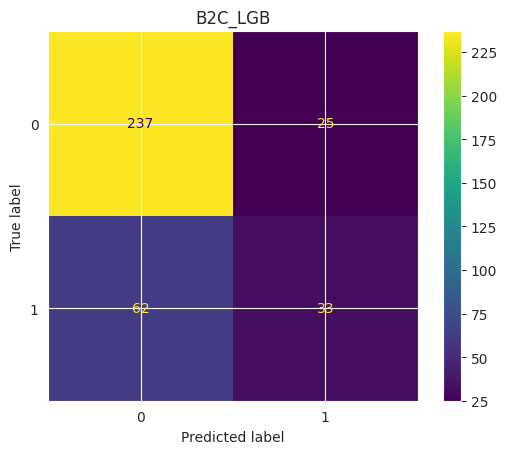

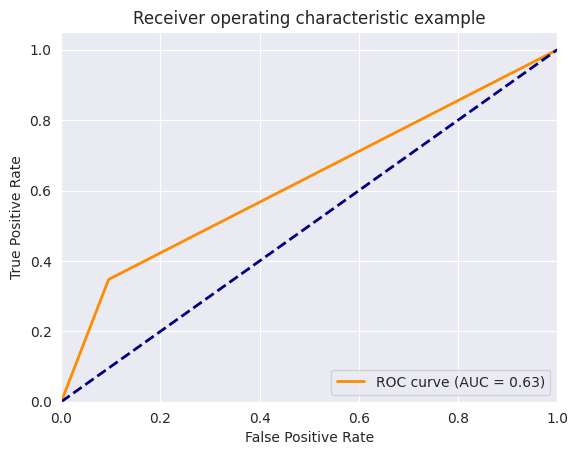

In [243]:
# get X and y data
X_b2c = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
y_b2c = df_train['B2C']
print('Shape of X_b2c = {}, y_b2c = {}'.format(X_b2c.shape, y_b2c.shape))

# optional - undersampling
rus = RandomUnderSampler(random_state=42)
X_b2c_resampled, y_b2c_resampled = rus.fit_resample(X_b2c, y_b2c)
print('Shape of X_b2c_resampled = {}, y_b2c_resampled = {}'.format(X_b2c_resampled.shape, y_b2c_resampled.shape))

# Choose appropriate X and y sets
# X_model, y_model = X_b2c_resampled, y_b2c_resampled
X_model, y_model = X_b2c, y_b2c

# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy score: ", study.best_value)

b2c_lgb_best_params = study.best_params

evaluate_model(model_name='B2C_LGB', best_params=study.best_params, X=X, y=y, tipo='B2C')

In [244]:
# evaluate_model(model_name='B2C_LGB', best_params=b2c_lgb_best_params, X=X, y=y, tipo='B2C')

## B2B MODEL

[I 2023-04-03 21:01:21,929] A new study created in memory with name: no-name-e6a86007-f170-4a84-89f4-e1b175f912f2
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-04-03 21:01:22,01

Training set shape: X_train = (270, 78), y_train = (270,)
Testing set shape: X_test = (68, 78), y_test = (68,)
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=10


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:22,168] Trial 1 finished with value: 0.5441176470588235 and parameters: {'lambda_l1': 7.878276879987252, 'lambda_l2': 9.707013998419265, 'num_leaves': 109, 'learning_rate': 0.30553548202876435, 'feature_fraction': 0.7960581432598204, 'bagging_fraction': 0.4945453017038094, 'bagging_freq': 4, 'min_child_samples': 70, 'min_data_in_leaf': 10, 'max_depth': 20, 'num_iterations': 595}. Best is trial 1 with value: 0.5441

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 21:01:22,512] Trial 4 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 6.855232872920548, 'lambda_l2': 8.986119716954942, 'num_leaves': 187, 'learning_rate': 0.30235427705462964, 'feature_fraction': 0.6206881746205286, 'bagging_fraction': 0.5682227599227571, 'bagging_freq': 3, 'min_child_samples': 67, 'min_data_in_leaf': 44, 'max_depth': 21, 'num_iterations': 671}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=8


[I 2023-04-03 21:01:22,755] Trial 6 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 6.834441594424634, 'lambda_l2': 6.211988651205163, 'num_leaves': 114, 'learning_rate': 0.06641631590548046, 'feature_fraction': 0.8952663689394533, 'bagging_fraction': 0.8620866525066425, 'bagging_freq': 5, 'min_child_samples': 56, 'min_data_in_leaf': 8, 'max_depth': 7, 'num_iterations': 243}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=18


[I 2023-04-03 21:01:23,024] Trial 8 finished with value: 0.6176470588235294 and parameters: {'lambda_l1': 3.198399084616507, 'lambda_l2': 6.059347486680282, 'num_leaves': 164, 'learning_rate': 0.9599792056926343, 'feature_fraction': 0.10034577879139964, 'bagging_fraction': 0.17796489648322494, 'bagging_freq': 5, 'min_child_samples': 98, 'min_data_in_leaf': 18, 'max_depth': 30, 'num_iterations': 211}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=72


[I 2023-04-03 21:01:23,400] Trial 10 finished with value: 0.6029411764705882 and parameters: {'lambda_l1': 0.15642572742796462, 'lambda_l2': 7.975400888563596, 'num_leaves': 55, 'learning_rate': 0.4237562692122388, 'feature_fraction': 0.4676394139556511, 'bagging_fraction': 0.9920269340676457, 'bagging_freq': 7, 'min_child_samples': 27, 'min_data_in_leaf': 72, 'max_depth': 24, 'num_iterations': 445}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 21:01:23,818] Trial 11 finished with value: 0.6176470588235294 and parameters: {'lambda_l1': 0.19356647575241115, 'lambda_l2': 7.42532957099198, 'num_leaves': 11, 'learning_rate': 0.18990689163485863, 'feature_fraction': 0.3365691254224815, 'bagging_fraction': 0.3926240020552668, 'bagging_freq': 1, 'min_child_samples': 33, 'min_data_in_leaf': 27, 'max_depth': 11, 'num_iterations': 782}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=65


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:24,354] Trial 13 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 9.600432640274537, 'lambda_l2': 7.497121686081462, 'num_leaves': 69, 'learning_rate': 0.021574966998227946, 'feature_fraction': 0.3304531891709389, 'bagging_fraction': 0.36747196037702357, 'bagging_freq': 7, 'min_child_samples': 38, 'min_data_in_leaf': 31, 'max_depth': 4, 'num_iterations': 978}. Best is trial 2 with value: 0.705

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=31


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:24,470] Trial 14 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 4.761319078384228, 'lambda_l2': 2.8399937353001627, 'num_leaves': 11, 'learning_rate': 0.39351549759234594, 'feature_fraction': 0.12391917009358783, 'bagging_fraction': 0.7336035357538016, 'bagging_freq': 2, 'min_child_samples': 77, 'min_data_in_leaf': 89, 'max_depth': 11, 'num_iterations': 109}. Best is trial 2 with value: 0.70

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=82


[I 2023-04-03 21:01:24,674] Trial 16 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 1.9163018481633611, 'lambda_l2': 2.552152666055048, 'num_leaves': 153, 'learning_rate': 0.3613234474508946, 'feature_fraction': 0.44479366180357865, 'bagging_fraction': 0.7679625816449034, 'bagging_freq': 2, 'min_child_samples': 72, 'min_data_in_leaf': 82, 'max_depth': 19, 'num_iterations': 110}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=86


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:25,042] Trial 19 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 5.200813184888268, 'lambda_l2': 6.979599599038459, 'num_leaves': 5, 'learning_rate': 0.35789782387809377, 'feature_fraction': 0.38689828904272167, 'bagging_fraction': 0.6105238473785961, 'bagging_freq': 2, 'min_child_samples': 64, 'min_data_in_leaf': 76, 'max_depth': 15, 'num_iterations': 330}. Best is trial 2 with value: 0.7058

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=59


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:25,255] Trial 21 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 5.64696710101849, 'lambda_l2': 2.257882108342887, 'num_leaves': 82, 'learning_rate': 0.445500981585503, 'feature_fraction': 0.27783109552615837, 'bagging_fraction': 0.7209621822385794, 'bagging_freq': 2, 'min_child_samples': 47, 'min_data_in_leaf': 97, 'max_depth': 11, 'num_iterations': 195}. Best is trial 2 with value: 0.705882

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=90


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:25,495] Trial 23 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 5.8734799624111265, 'lambda_l2': 1.628193680103586, 'num_leaves': 86, 'learning_rate': 0.5331148157216854, 'feature_fraction': 0.1846922099567793, 'bagging_fraction': 0.7798350271966722, 'bagging_freq': 3, 'min_child_samples': 56, 'min_data_in_leaf': 90, 'max_depth': 13, 'num_iterations': 300}. Best is trial 2 with value: 0.7058

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=80


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:25,739] Trial 25 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 2.9745019647803916, 'lambda_l2': 1.9450434693201117, 'num_leaves': 112, 'learning_rate': 0.4578720482143536, 'feature_fraction': 0.23106801694804535, 'bagging_fraction': 0.7706637901389691, 'bagging_freq': 2, 'min_child_samples': 48, 'min_data_in_leaf': 94, 'max_depth': 18, 'num_iterations': 381}. Best is trial 2 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=68


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:26,000] Trial 27 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 5.136206806931263, 'lambda_l2': 0.1585007402001657, 'num_leaves': 30, 'learning_rate': 0.24846790018081766, 'feature_fraction': 0.4070809057268889, 'bagging_fraction': 0.9152986060797106, 'bagging_freq': 4, 'min_child_samples': 75, 'min_data_in_leaf': 83, 'max_depth': 8, 'num_iterations': 250}. Best is trial 2 with value: 0.7058

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-04-03 21:01:26,234] Trial 29 finished with value: 0.4411764705882353 and parameters: {'lambda_l1': 3.7989952538251757, 'lambda_l2':

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:26,474] Trial 31 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 1.979517312646618, 'lambda_l2': 2.5030204150809356, 'num_leaves': 169, 'learning_rate': 0.35966734870605155, 'feature_fraction': 0.4611257681195957, 'bagging_fraction': 0.7598937711478102, 'bagging_freq': 2, 'min_child_samples': 72, 'min_data_in_leaf': 79, 'max_depth': 19, 'num_iterations': 105}. Best is trial 2 with value: 0.70

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=86


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:26,709] Trial 33 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 0.7512871376926835, 'lambda_l2': 1.8231344701448924, 'num_leaves': 124, 'learning_rate': 0.42427370302966205, 'feature_fraction': 0.19799429624549875, 'bagging_fraction': 0.7684822300949764, 'bagging_freq': 1, 'min_child_samples': 74, 'min_data_in_leaf': 76, 'max_depth': 14, 'num_iterations': 221}. Best is trial 2 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=92


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:26,924] Trial 35 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 1.9199160657386385, 'lambda_l2': 3.6497799422318193, 'num_leaves': 142, 'learning_rate': 0.28916561319983014, 'feature_fraction': 0.4268531399524464, 'bagging_fraction': 0.6968953655043284, 'bagging_freq': 3, 'min_child_samples': 66, 'min_data_in_leaf': 51, 'max_depth': 27, 'num_iterations': 101}. Best is trial 2 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=72


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:27,169] Trial 37 finished with value: 0.5 and parameters: {'lambda_l1': 0.7376602132099404, 'lambda_l2': 2.827173939093051, 'num_leaves': 121, 'learning_rate': 0.22731015531682175, 'feature_fraction': 0.24581174765550334, 'bagging_fraction': 0.5678226270707347, 'bagging_freq': 5, 'min_child_samples': 68, 'min_data_in_leaf': 83, 'max_depth': 6, 'num_iterations': 235}. Best is trial 2 with value: 0.7058823529411765.

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=64


[I 2023-04-03 21:01:27,361] Trial 38 finished with value: 0.6176470588235294 and parameters: {'lambda_l1': 3.7580385303663157, 'lambda_l2': 1.9203121214952152, 'num_leaves': 183, 'learning_rate': 0.48567087146377863, 'feature_fraction': 0.1605931106197735, 'bagging_fraction': 0.6467546566689536, 'bagging_freq': 3, 'min_child_samples': 80, 'min_data_in_leaf': 64, 'max_depth': 15, 'num_iterations': 747}. Best is trial 2 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=76


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:27,715] Trial 41 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 6.1642961049773195, 'lambda_l2': 0.8433676792898905, 'num_leaves': 85, 'learning_rate': 0.5247156217801978, 'feature_fraction': 0.16006412350559795, 'bagging_fraction': 0.7580391446679927, 'bagging_freq': 3, 'min_child_samples': 56, 'min_data_in_leaf': 92, 'max_depth': 13, 'num_iterations': 301}. Best is trial 2 with value: 0.70

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=89


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:27,967] Trial 43 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 7.306317355587688, 'lambda_l2': 1.557822563147604, 'num_leaves': 81, 'learning_rate': 0.6460996558495444, 'feature_fraction': 0.26449349753458495, 'bagging_fraction': 0.7324264654858509, 'bagging_freq': 3, 'min_child_samples': 93, 'min_data_in_leaf': 82, 'max_depth': 10, 'num_iterations': 254}. Best is trial 2 with value: 0.7058

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:28,245] Trial 45 finished with value: 0.7352941176470589 and parameters: {'lambda_l1': 4.845831003733437, 'lambda_l2': 2.707324700562131, 'num_leaves': 156, 'learning_rate': 0.4801067297601926, 'feature_fraction': 0.3676005509108761, 'bagging_fraction': 0.7956232698295816, 'bagging_freq': 3, 'min_child_samples': 70, 'min_data_in_leaf': 95, 'max_depth': 8, 'num_iterations': 601}. Best is trial 45 with value: 0.7352

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=95


[I 2023-04-03 21:01:28,377] Trial 46 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 4.697240957679647, 'lambda_l2': 2.7362908845496228, 'num_leaves': 156, 'learning_rate': 0.4770414457497531, 'feature_fraction': 0.355175886746264, 'bagging_fraction': 0.6869209229159189, 'bagging_freq': 1, 'min_child_samples': 69, 'min_data_in_leaf': 95, 'max_depth': 7, 'num_iterations': 650}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=70


[I 2023-04-03 21:01:28,764] Trial 48 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 3.098749198736032, 'lambda_l2': 4.655232977941514, 'num_leaves': 140, 'learning_rate': 0.173074179877379, 'feature_fraction': 0.38204952706385303, 'bagging_fraction': 0.8670846947554844, 'bagging_freq': 2, 'min_child_samples': 65, 'min_data_in_leaf': 70, 'max_depth': 4, 'num_iterations': 752}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=55


[I 2023-04-03 21:01:29,126] Trial 50 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 6.596546011253956, 'lambda_l2': 3.8364163305613586, 'num_leaves': 158, 'learning_rate': 0.362533926683004, 'feature_fraction': 0.4343955318925776, 'bagging_fraction': 0.6655819145761899, 'bagging_freq': 3, 'min_child_samples': 40, 'min_data_in_leaf': 55, 'max_depth': 23, 'num_iterations': 588}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=92


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:29,578] Trial 53 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 4.964055082186565, 'lambda_l2': 2.2601381839158323, 'num_leaves': 87, 'learning_rate': 0.5318261510495607, 'feature_fraction': 0.22007364015709902, 'bagging_fraction': 0.7951701522404289, 'bagging_freq': 3, 'min_child_samples': 77, 'min_data_in_leaf': 97, 'max_depth': 12, 'num_iterations': 691}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=84


[I 2023-04-03 21:01:29,745] Trial 54 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 5.578118482321671, 'lambda_l2': 2.5237285529113267, 'num_leaves': 61, 'learning_rate': 0.3179449522380595, 'feature_fraction': 0.35487703825316774, 'bagging_fraction': 0.6964725225422383, 'bagging_freq': 5, 'min_child_samples': 70, 'min_data_in_leaf': 84, 'max_depth': 14, 'num_iterations': 493}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=90


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:30,105] Trial 57 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 4.262472755249295, 'lambda_l2': 2.9756887014369022, 'num_leaves': 150, 'learning_rate': 0.6619556718036472, 'feature_fraction': 0.3833316365805112, 'bagging_fraction': 0.8161850659475148, 'bagging_freq': 1, 'min_child_samples': 63, 'min_data_in_leaf': 94, 'max_depth': 20, 'num_iterations': 276}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=95


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:30,381] Trial 59 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 4.161402314860855, 'lambda_l2': 3.1518065758644003, 'num_leaves': 175, 'learning_rate': 0.7042515139425317, 'feature_fraction': 0.49463897475296426, 'bagging_fraction': 0.9159784728058741, 'bagging_freq': 1, 'min_child_samples': 64, 'min_data_in_leaf': 100, 'max_depth': 21, 'num_iterations': 362}. Best is trial 45 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=95


[I 2023-04-03 21:01:30,562] Trial 60 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 4.274765819833413, 'lambda_l2': 3.147119058605291, 'num_leaves': 216, 'learning_rate': 0.6564296432747566, 'feature_fraction': 0.49359587022749524, 'bagging_fraction': 0.9298365180139554, 'bagging_freq': 1, 'min_child_samples': 62, 'min_data_in_leaf': 95, 'max_depth': 25, 'num_iterations': 455}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=97


[I 2023-04-03 21:01:30,863] Trial 62 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 4.0234682704283005, 'lambda_l2': 2.8732163117837333, 'num_leaves': 173, 'learning_rate': 0.6893131266744297, 'feature_fraction': 0.41250727283651556, 'bagging_fraction': 0.9691206468219972, 'bagging_freq': 1, 'min_child_samples': 64, 'min_data_in_leaf': 97, 'max_depth': 20, 'num_iterations': 374}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future relea

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=96


[I 2023-04-03 21:01:31,145] Trial 64 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 3.971372747696025, 'lambda_l2': 3.400622658685508, 'num_leaves': 178, 'learning_rate': 0.729422692447277, 'feature_fraction': 0.39926662965331117, 'bagging_fraction': 0.951489917369383, 'bagging_freq': 1, 'min_child_samples': 63, 'min_data_in_leaf': 96, 'max_depth': 21, 'num_iterations': 419}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=93


[I 2023-04-03 21:01:31,476] Trial 66 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 3.4893660204847783, 'lambda_l2': 4.057545780454987, 'num_leaves': 204, 'learning_rate': 0.7746768472853716, 'feature_fraction': 0.4818615183871496, 'bagging_fraction': 0.8954987364041889, 'bagging_freq': 1, 'min_child_samples': 53, 'min_data_in_leaf': 93, 'max_depth': 18, 'num_iterations': 466}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=97


[I 2023-04-03 21:01:31,780] Trial 68 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 3.26309193094682, 'lambda_l2': 2.5567484829466425, 'num_leaves': 149, 'learning_rate': 0.676234426395085, 'feature_fraction': 0.38479669380476245, 'bagging_fraction': 0.8941015430759978, 'bagging_freq': 1, 'min_child_samples': 57, 'min_data_in_leaf': 97, 'max_depth': 20, 'num_iterations': 278}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=86


[I 2023-04-03 21:01:32,113] Trial 70 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 4.084350843991009, 'lambda_l2': 2.0241500177456513, 'num_leaves': 174, 'learning_rate': 0.6178414923695644, 'feature_fraction': 0.4596169672066016, 'bagging_fraction': 0.9215089580467343, 'bagging_freq': 1, 'min_child_samples': 49, 'min_data_in_leaf': 86, 'max_depth': 23, 'num_iterations': 351}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=89


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:32,553] Trial 73 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 2.885474213779869, 'lambda_l2': 2.961195752324782, 'num_leaves': 148, 'learning_rate': 0.6501495433044651, 'feature_fraction': 0.4189827965501199, 'bagging_fraction': 0.973019383426168, 'bagging_freq': 7, 'min_child_samples': 67, 'min_data_in_leaf': 98, 'max_depth': 21, 'num_iterations': 313}. Best is trial 45 with value: 0.7352

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=95


[I 2023-04-03 21:01:32,716] Trial 74 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 4.286995993688484, 'lambda_l2': 2.6358604181053513, 'num_leaves': 202, 'learning_rate': 0.821725532606825, 'feature_fraction': 0.31541077865023104, 'bagging_fraction': 0.9188896737734854, 'bagging_freq': 1, 'min_child_samples': 63, 'min_data_in_leaf': 95, 'max_depth': 22, 'num_iterations': 420}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=100


[I 2023-04-03 21:01:33,021] Trial 76 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 5.212755623094864, 'lambda_l2': 3.1625213083220216, 'num_leaves': 161, 'learning_rate': 0.6278472609126987, 'feature_fraction': 0.47914805631249835, 'bagging_fraction': 0.8484689961243018, 'bagging_freq': 1, 'min_child_samples': 77, 'min_data_in_leaf': 100, 'max_depth': 17, 'num_iterations': 265}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future relea

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=92


[I 2023-04-03 21:01:33,326] Trial 78 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 4.650138385078983, 'lambda_l2': 3.6329844498669392, 'num_leaves': 183, 'learning_rate': 0.6846431663121422, 'feature_fraction': 0.4438039007557865, 'bagging_fraction': 0.995205195856398, 'bagging_freq': 6, 'min_child_samples': 59, 'min_data_in_leaf': 92, 'max_depth': 29, 'num_iterations': 387}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=86


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:33,733] Trial 81 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 2.610808098115281, 'lambda_l2': 3.865087499986283, 'num_leaves': 126, 'learning_rate': 0.6696512956694087, 'feature_fraction': 0.4022502568929138, 'bagging_fraction': 0.9600136323495655, 'bagging_freq': 1, 'min_child_samples': 95, 'min_data_in_leaf': 94, 'max_depth': 28, 'num_iterations': 185}. Best is trial 45 with value: 0.735

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=94


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:34,011] Trial 83 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 4.200605184829007, 'lambda_l2': 4.2982831611096834, 'num_leaves': 146, 'learning_rate': 0.6386669966452078, 'feature_fraction': 0.3714307410914154, 'bagging_fraction': 0.9173166913281043, 'bagging_freq': 1, 'min_child_samples': 86, 'min_data_in_leaf': 97, 'max_depth': 30, 'num_iterations': 295}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=91


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:34,295] Trial 85 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 3.682998165740552, 'lambda_l2': 3.077343992180024, 'num_leaves': 132, 'learning_rate': 0.6675129577138922, 'feature_fraction': 0.4466280969570675, 'bagging_fraction': 0.9058209136307668, 'bagging_freq': 1, 'min_child_samples': 100, 'min_data_in_leaf': 98, 'max_depth': 29, 'num_iterations': 275}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=94


[I 2023-04-03 21:01:34,510] Trial 86 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 4.001016151626094, 'lambda_l2': 3.9742624035587295, 'num_leaves': 174, 'learning_rate': 0.7118748960339754, 'feature_fraction': 0.4115895230346037, 'bagging_fraction': 0.9758205424888942, 'bagging_freq': 1, 'min_child_samples': 95, 'min_data_in_leaf': 94, 'max_depth': 26, 'num_iterations': 186}. Best is trial 45 with value: 0.7352941176470589.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=89


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:35,070] Trial 88 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 2.923774529831324, 'lambda_l2': 2.7848955210218276, 'num_leaves': 194, 'learning_rate': 0.6239311306354176, 'feature_fraction': 0.39048785080963144, 'bagging_fraction': 0.8804542238884119, 'bagging_freq': 1, 'min_child_samples': 91, 'min_data_in_leaf': 84, 'max_depth': 25, 'num_iterations': 347}. Best is trial 45 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=84


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:35,319] Trial 89 finished with value: 0.5735294117647058 and parameters: {'lambda_l1': 4.420540063325632, 'lambda_l2': 2.3854464915045255, 'num_leaves': 178, 'learning_rate': 0.7432025979086707, 'feature_fraction': 0.31518224045196375, 'bagging_fraction': 0.9891661142049076, 'bagging_freq': 1, 'min_child_samples': 86, 'min_data_in_leaf': 80, 'max_depth': 26, 'num_iterations': 234}. Best is trial 45 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=80


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:35,548] Trial 90 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 3.8494887050752578, 'lambda_l2': 3.4035889268652575, 'num_leaves': 157, 'learning_rate': 0.5877390285153257, 'feature_fraction': 0.4238972968162672, 'bagging_fraction': 0.8349293926785664, 'bagging_freq': 2, 'min_child_samples': 97, 'min_data_in_leaf': 100, 'max_depth': 20, 'num_iterations': 195}. Best is trial 45 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:35,802] Trial 91 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 4.177755870959864, 'lambda_l2': 4.172218462936227, 'num_leaves': 129, 'learning_rate': 0.6386446901166437, 'feature_fraction': 0.38140445962046154, 'bagging_fraction': 0.9132896309441901, 'bagging_freq': 1, 'min_child_samples': 85, 'min_data_in_leaf': 97, 'max_depth': 29, 'num_iterations': 291}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=97


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:36,031] Trial 92 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 4.126338099852239, 'lambda_l2': 4.391267469178753, 'num_leaves': 187, 'learning_rate': 0.6547170320663109, 'feature_fraction': 0.35859796089183466, 'bagging_fraction': 0.9348149642230308, 'bagging_freq': 1, 'min_child_samples': 88, 'min_data_in_leaf': 96, 'max_depth': 30, 'num_iterations': 249}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=96


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:36,267] Trial 93 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 4.664566814073372, 'lambda_l2': 4.568848512674837, 'num_leaves': 146, 'learning_rate': 0.7018562534918825, 'feature_fraction': 0.37411036236975476, 'bagging_fraction': 0.9036585833052168, 'bagging_freq': 1, 'min_child_samples': 70, 'min_data_in_leaf': 92, 'max_depth': 30, 'num_iterations': 320}. Best is trial 45 with value: 0.73

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=92


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:36,502] Trial 94 finished with value: 0.7205882352941176 and parameters: {'lambda_l1': 3.687444494255159, 'lambda_l2': 3.8709769390599824, 'num_leaves': 144, 'learning_rate': 0.6354622693884119, 'feature_fraction': 0.34104784013959266, 'bagging_fraction': 0.8636843670247778, 'bagging_freq': 1, 'min_child_samples': 90, 'min_data_in_leaf': 98, 'max_depth': 27, 'num_iterations': 292}. Best is trial 45 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=98


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:36,808] Trial 95 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 4.335502183734266, 'lambda_l2': 3.2231381289152052, 'num_leaves': 153, 'learning_rate': 0.6753613892268133, 'feature_fraction': 0.45363148938409503, 'bagging_fraction': 0.9093401130220418, 'bagging_freq': 1, 'min_child_samples': 83, 'min_data_in_leaf': 88, 'max_depth': 28, 'num_iterations': 555}. Best is trial 45 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=88


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:37,053] Trial 96 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 5.103759670707619, 'lambda_l2': 4.174749012637585, 'num_leaves': 118, 'learning_rate': 0.6128019037716345, 'feature_fraction': 0.29554284725511537, 'bagging_fraction': 0.960724919401708, 'bagging_freq': 2, 'min_child_samples': 86, 'min_data_in_leaf': 93, 'max_depth': 16, 'num_iterations': 365}. Best is trial 45 with value: 0.735

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=93


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:37,352] Trial 97 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 4.868223436238076, 'lambda_l2': 2.896883896999166, 'num_leaves': 169, 'learning_rate': 0.7171952237379177, 'feature_fraction': 0.4001841880559836, 'bagging_fraction': 0.9999692072489231, 'bagging_freq': 1, 'min_child_samples': 80, 'min_data_in_leaf': 96, 'max_depth': 22, 'num_iterations': 693}. Best is trial 45 with value: 0.735

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=96


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:37,669] Trial 98 finished with value: 0.6911764705882353 and parameters: {'lambda_l1': 3.385780456135676, 'lambda_l2': 3.751666799812508, 'num_leaves': 161, 'learning_rate': 0.7424389954807549, 'feature_fraction': 0.47534506584723346, 'bagging_fraction': 0.936225382933004, 'bagging_freq': 1, 'min_child_samples': 98, 'min_data_in_leaf': 98, 'max_depth': 28, 'num_iterations': 624}. Best is trial 45 with value: 0.735

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=98


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 21:01:37,898] Trial 99 finished with value: 0.7352941176470589 and parameters: {'lambda_l1': 3.9290526597749524, 'lambda_l2': 2.6263792634363057, 'num_leaves': 137, 'learning_rate': 0.6913257976212849, 'feature_fraction': 0.4412370079282757, 'bagging_fraction': 0.8761167037010583, 'bagging_freq': 1, 'min_child_samples': 65, 'min_data_in_leaf': 91, 'max_depth': 19, 'num_iterations': 205}. Best is trial 45 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=91
Best hyperparameters:  {'lambda_l1': 4.845831003733437, 'lambda_l2': 2.707324700562131, 'num_leaves': 156, 'learning_rate': 0.4801067297601926, 'feature_fraction': 0.3676005509108761, 'bagging_fraction': 0.7956232698295816, 'bagging_freq': 3, 'min_child_samples': 70, 'min_data_in_leaf': 95, 'max_depth': 8, 'num_iterations': 601}
Best accuracy score:  0.7352941176470589
Training set shape: X_train = (1424, 78), y_train = (1424, 2)
Testing set shape: X_test = (357, 78), y_test = (357, 2)
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] lambda_l1 is set=4.845831003733437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845831003733437
[LightGBM] [Warning] bagging_fraction is set=0.7956232698295816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7956232698295816
[LightGBM] [Warning] lambda_l2 is set=2.707324700562131, reg_l

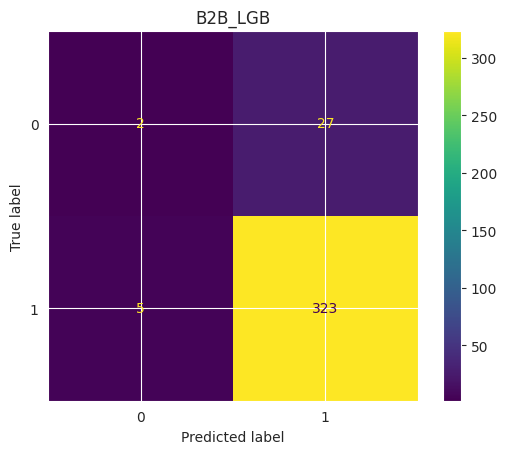

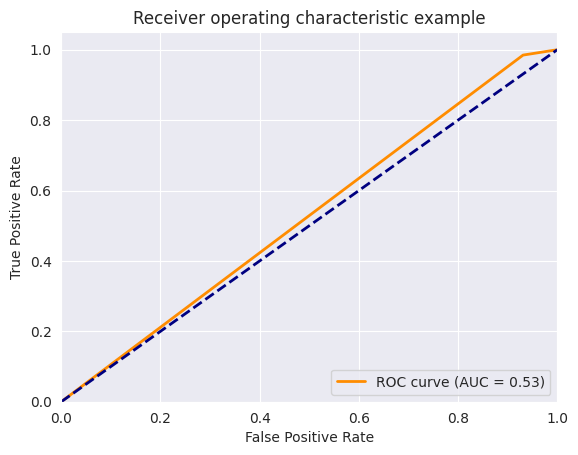

In [245]:
# get X and y data
X_b2b = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
y_b2b = df_train['B2B']

# optional - undersampling
rus = RandomUnderSampler(random_state=42)
X_b2b_resampled, y_b2b_resampled = rus.fit_resample(X_b2b, y_b2b)

# Choose appropriate X and y sets
X_model, y_model = X_b2b_resampled, y_b2b_resampled
# X_model, y_model = X_b2b, y_b2b


# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy score: ", study.best_value)

b2b_lgb_best_params = study.best_params

evaluate_model(model_name='B2B_LGB', best_params=study.best_params, X=X, y=y, tipo='B2B')

In [246]:
# evaluate_model(model_name='B2B_LGB', best_params=b2b_lgb_best_params, X=X, y=y, tipo='B2B')

# Saving the Trained Models
---

In [247]:
import pickle

# B2C
# ------------------------------------------------------------
# get X and y data
X = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
y_b2c = df_train['B2C']

# Train the LGBM model using the best hyperparameters
model_b2c = lgb.LGBMClassifier(**b2c_lgb_best_params, gpu_id=device_id)
model_b2c.fit(X, y_b2c)

# Make predictions on test data
y_pred_b2c = model_b2c.predict(X)

# Convert probabilities to binary labels
y_pred_binary_b2c = y_pred_b2c.round().astype(int)

# Save the model to a file using pickle
with open('b2c_model.pkl', 'wb') as f:
    pickle.dump(model_b2c, f)


# B2B
# -----------------------------------------------------------
# get X and y data
X = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
y_b2b = df_train['B2B']

# Train the LGBM model using the best hyperparameters
model_b2b = lgb.LGBMClassifier(**b2b_lgb_best_params, gpu_id=device_id)
model_b2b.fit(X, y_b2b)

# Make predictions on test data
y_pred_b2b = model_b2b.predict(X)

# Convert probabilities to binary labels
y_pred_binary = y_pred_b2b.round().astype(int)

# Save the model to a file using pickle
with open('b2b_model.pkl', 'wb') as f:
    pickle.dump(model_b2b, f)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] lambda_l1 is set=4.768115548905071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.768115548905071
[LightGBM] [Warning] bagging_fraction is set=0.9296372542156885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296372542156885
[LightGBM] [Warning] lambda_l2 is set=1.9676247789817762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9676247789817762
[LightGBM] [Warning] feature_fraction is set=0.8415021111115882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415021111115882
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] lambda_l1 is set=4.845831003733437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845831003733437
[LightGBM] [Warning] bagging_fraction is set=0.7956232698295816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7956232698295816
[LightGBM] [Warning] lambda_l2 is set=2.707324700562131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.707324700562131
[LightGBM] [Warning] feature_fraction is set=0.3676005509108761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3676005509108761
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


# Appending Predictions to Original DF
---


In [248]:
df_final = df.copy()

df_final['B2B_pred'] = y_pred_b2b
df_final['B2C_pred'] = y_pred_b2c

df_final.to_csv('df_final.to_csv')

In [250]:
df_final[['name', 'type', 'B2C_pred', 'B2B_pred']][:50]

,name,type,B2C_pred,B2B_pred
0,Supli,B2B,0,1
1,Bandwidth Recruitment,B2B,0,1
2,VCV.AI,B2B,0,1
3,"Scalable Press Employees, Location, Careers",B2B B2C,1,1
4,Stuffwrap,B2C,1,0
5,VirtualExpo Careers and Current Employee Profiles,B2B,0,1
6,asuro,B2B B2C,1,1
7,nextcept,B2B,0,1
8,ClientsFirst,B2B,0,1
9,geo-Advantage,B2B,0,1


# Final Considerations
---

This was a very fun problem to work on. Sadly, due to time constraints, I did not have too much time to properly tune the models, experiment with different architectures and test different sets of features for model improvement. 

I do believe that the path chosen to tackle this problem is a correct one, and that the model performance can improve greatly with the required time and research.


### Text Features
---
The text features and categories chosen for this model were personally developed by me, and with more experimentation we could discover that some of them do not aid the model in making predictions. Given that this is just an example, I have not tried different sets of features on each model to check for performance improvement.

Also, using the companies' description as a means to text feature extraction would have been great. If it wasn't for the time, I definetively would've tried it.

### Scaling
---

Different scaling methods could be used for feature scaling, and should be considered on future tests/

### Class Imbalance
---

I have used Undersampling to tackle this problem. Other solutions would be to simply get more data on the minority class, use different algorithms (*upsampling*, for example), or try different model architectures and loss functions (*accuracy* is **BAD** for dealing with class imbalance)

### Model Selection and Performance Metrics
---

Different models could be used for this problem. Simple logistic regressions, to random forests to deep neural networks. Deciding which architecture to use is a matter of research and, just as importantly, of trial and error. With more time to work on the problem, more methods could arise.

### Multi-Label approach
----

This clearly consists of a multilabel classification problem. Nevertheless, using a single model to predict the labels could be interesting, given that B2C and B2B categories do share some common aspects that a single model could absorb.

One could use a single multilabel LGBM model for classification, instead of training separate models.

### Results
---

The accuracy scores were not bad, but they are clearly misleading. As the seen on the confusion matrix and AUC curve, the model had a hard time escaping the class-imbalance problem, having mostly predicted the majority class.